# **Malaria Detection**

####<b>Problem Definition</b>

There are 241 milion cases of malaria in 2021 with 12% mortality, effecting more than 85 countries. Symptoms of malaria are fever, shaking chills, headache, tiredness, vomiting and diarrhea. It can also cause anemia, jaundice and in the worst cases it could cause result in deaths.

There are 5 species of malaria that can infect human and each have 4 major stages of life cycle.

Malaria infection can be detected via examination of patient's blood smear stained using Giemsa stain on microscope slide by skilled technicians. The shortage of technicians could lead to false diagnosis which can increase the mortality rate of patients. 

Here, we explored an alternative method using deep neural network which can produce an automated model to perform classification using blood smear cell image. This method can be a more accurate, convenient and economical method of malaria detection for patients.

####<b>Goal:</b>
This notebook will explore the effectiveness of several custom CNN models and VGG-19 model, pre-processing techniques and attempt to find the most optimal CNN model and pre-processing technique for use in malaria detection.

Note: repeated code to initiate same model architecture to be trained on different pre-processed images have been removed to keep the notebook tidy and readable and some plots have been moved from their original spots in the notebook and grouped together to allow easier comparison of model performance based on different preprocessing techniques

## <b>Data Description </b>

There are a total of 24,958 train and 2,600 test images (colored) that we have taken from microscopic images. These images are of the following categories:<br>


**Parasitized:** The parasitized cells contain the Plasmodium parasite which causes malaria<br>
**Uninfected:** The uninfected cells are free of the Plasmodium parasites<br>


###<b> Mount the Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### <b>Loading libraries</b>

In [2]:
import cv2
from google.colab.patches import cv2_imshow
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import zipfile
from PIL import Image
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, LeakyReLU, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras.applications.vgg16 import VGG16
import warnings

np.random.seed(42)

### <b>Let us load the data</b>

In [3]:
path = '/content/drive/My Drive/Colab Notebooks/cell_images.zip'
with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall()

The extracted folder has different folders for train and test data will contain the different sizes of images for parasitized and uninfected cells within the respective folder name. 

The size of all images must be the same and should be converted to 4D arrays so that they can be used as an input for the convolutional neural network. Also, we need to create the labels for both types of images to be able to train and test the model. 

Let's do the same for the training data first and then we will use the same code for the test data as well.

In [4]:
image_size = 64
train_images = []
train_labels = []
test_images = []
test_labels = []

for dir in ['/content/cell_images/train', '/content/cell_images/test']:
  data_type = dir.replace('/content/cell_images/', '')
  for cell_type in ['/parasitized/', '/uninfected/']:
      images_path = os.listdir(dir + cell_type)
      for i, image_name in enumerate(images_path):
          try:   
              image = Image.open(dir + cell_type + image_name)
              image = image.resize((image_size, image_size))
              globals()[data_type + '_images'].append(np.asarray(image))
              if cell_type == '/parasitized/':          
                  globals()[data_type + '_labels'].append(1)        
              else:       
                  globals()[data_type + '_labels'].append(0)      
          except Exception as e: print(e)

  globals()[data_type + '_images'] = np.array(globals()[data_type + '_images'])
  globals()[data_type + '_labels'] = np.array(globals()[data_type + '_labels'])

###<b> Check the shape of train and test images

In [ ]:
print(f'train images shape: %s'% (train_images.shape,))
print(f'test images shape: %s'% (test_images.shape,))

train images shape: (24958, 64, 64, 3)
test images shape: (2600, 64, 64, 3)


###<b> Check the shape of train and test labels

In [ ]:
print(f'train labels shape: %s'% (train_labels.shape,))
print(f'test labels shape: %s'% (test_labels.shape,))

train labels shape: (24958,)
test labels shape: (2600,)


####<b> Observations and insights:</b>
*   There are 24958 images in train folder, each image has shape of (64, 64, 3)
*   There are 2600 images in test folder, each image has shape of (64, 64, 3)
*   Each cell in the array corresponds to a pixel in the image, here, each image is 64x64 pixels
*   The images given are RGB images, each pixel comprise of 3 channels: red, green and blue, stored as 3D-array


### <b>Check the minimum and maximum range of pixel values for train and test images

In [ ]:
print('min: ' + str(train_images.min()))
print('max: ' + str(train_images.max()))
print('min: ' + str(test_images.min()))
print('max: ' + str(test_images.max()))

min: 0
max: 255
min: 0
max: 255


####<b> Observations and insights:</b>
*   The range of number for each pixel is 0-255, this is because each colour channel is 8bit, representing red, green and blue light.

###<b> Count the number of values in both uninfected and parasitized 

In [ ]:
print(pd.Series(train_labels).value_counts())
print(pd.Series(test_labels).value_counts())

1    12582
0    12376
dtype: int64
1    1300
0    1300
dtype: int64


###<b>Normalize the images

In [5]:
norm_train_images = (train_images/255.0).astype('float32')
norm_test_images = (test_images/255.0).astype('float32')

####<b> Observations and insights:</b>
*   To normalize the image to have the range between 0-1, we devide each value in the image array by 255 where 0 means 0 (0x00) and 1.0 means 255 (0xFF)
*   RGB values are normally stored as integers to save memory, however, normalization is done on image inputs into CNN to make computation faster.

###<b> Plot to check if the data is balanced

<Axes: title={'center': 'data distribution'}, xlabel='type of data', ylabel='number of samples'>

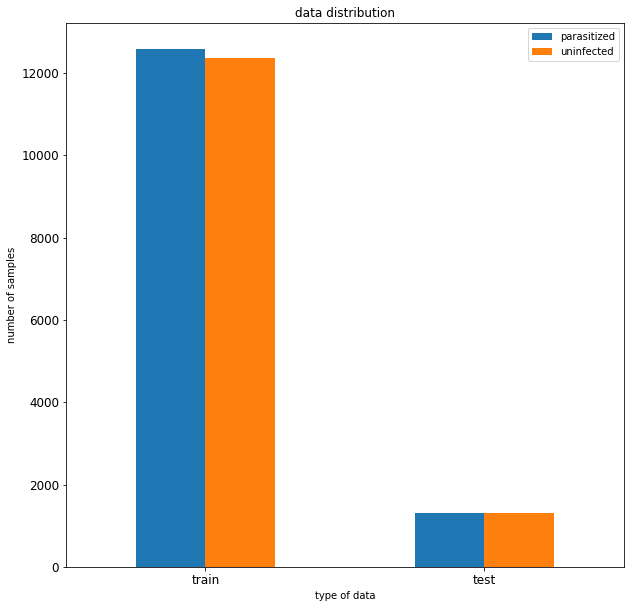

In [ ]:
c=pd.concat([(pd.Series(train_labels).value_counts().to_frame()),(pd.Series(test_labels).value_counts().to_frame())], axis=1)
c.columns = ['train', 'test']
c.index = ['parasitized', 'uninfected']
c=c.T

c.plot.bar(title='data distribution', xlabel="type of data", ylabel="number of samples", fontsize='large', rot=0 , width = 0.5,figsize=(10,10))


####<b> Observations and insights:</b>
*   There are 12582 images of parasitized cell in train set, 50.4% of the total number of images and 12376 images of uninfected cell amounting to 49.6% of all train images
*   There are equal number parasitized and uninfected cell images i.e. exactly 50% of each type of images
*   Therefore both train and test datasets are balanced as the number of parasitized and uninfected cell images are roughly 50% for both train and test datasets



### <b>Data Exploration</b>
Let's visualize the images from the train data

In [ ]:
#creating function to plot images taking in 5 arguments
def plot_images(x,y, size, pic_arr,label_arr):
  number_pic=x*y
  number_pic=number_pic+1
  picture_index_arr = random.sample(range(pic_arr.shape[0]-1), number_pic)
  plt.figure(1, figsize = (size , size))
  for n in range(1, number_pic):
    plt.subplot(x,y,n)
    img = pic_arr[picture_index_arr[n]]
    plt.imshow(pic_arr[picture_index_arr[n]])
    if label_arr[picture_index_arr[n]] == 1: 
        plt.title('parasitized')
    else:
        plt.title('uninfected')
    plt.axis('off')

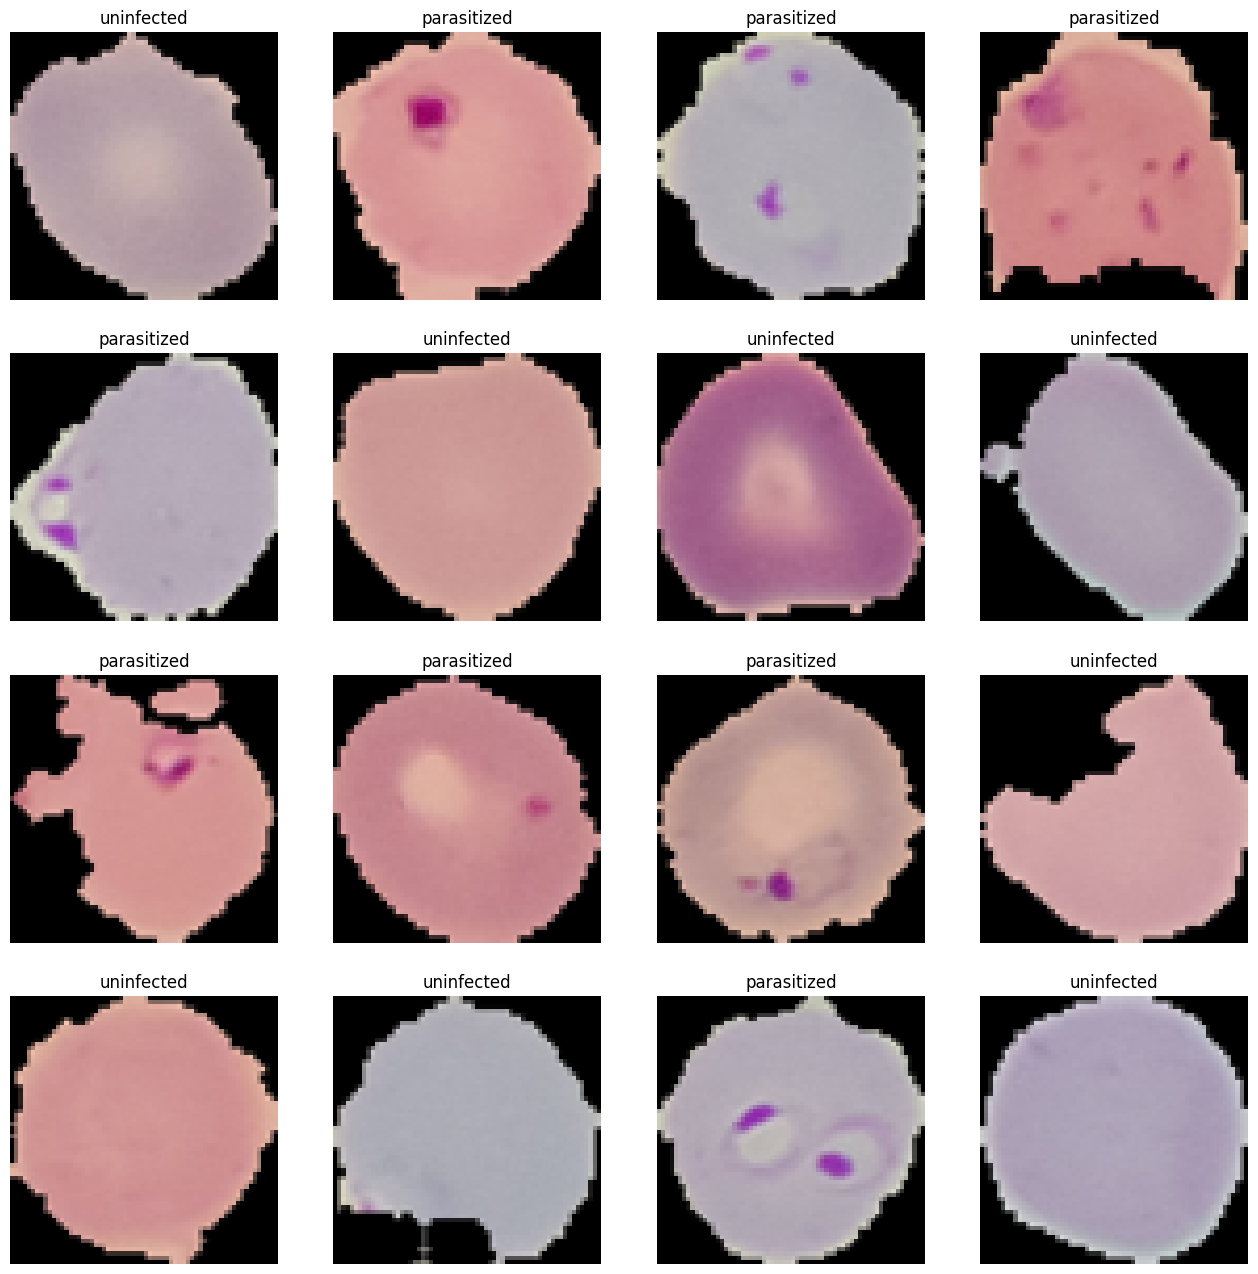

In [ ]:
plot_images(4,4,16,train_images,train_labels)

####<b> Observations and insights:</b>
*   The images have low resolution
*   Cell color ranges from light purple to lilac but the color of the cell does not have a strong correlation to the cell being parasitized or uninfected
*   Parasitized cells contain circular dark purple dot(s) denoting the presence of parasite in cell and haemozoin which is a disposal product of malaria parasites and also some other parasites while uninfected cell do not contain these dark purple dots - the dots are not uniform in shape and can be anywhere in the cell
*   Most cells are circular in shape, some cells have irregularities, more cells with shape irregularities are parasitized cells but some uninfected cells also have shape irregularities



###<b> Visualize the images with subplot(6, 6) and figsize = (12, 12)

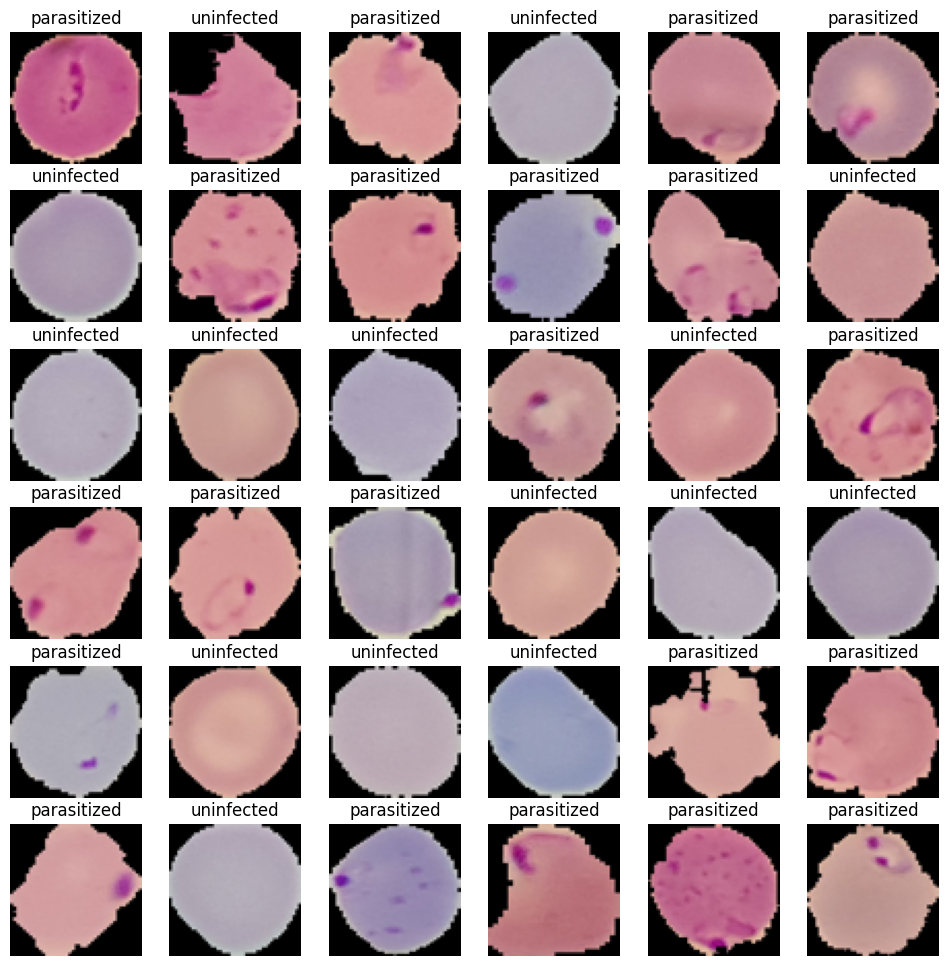

In [ ]:
plot_images(6,6,12,train_images,train_labels)

####<b>Observations and insights:</b>
*   Same observations as previously observed
*   We can also see here some cells have one large white circular spot in the middle of the cell which does not seem to be an indication of whether if cell is parasitized or uninfected i.e. noise
*   We can see here that some parasitized cells purple dot(s) are very small and in some pictures, blurry - this may not be detected by the CNN and result in false negatives


###<b> Plotting the mean images for parasitized and uninfected

In [ ]:
# create a function to show the image the average image from array of images
def find_mean_img(pic_arr, title):
  mean_img = np.mean(pic_arr, axis = 0)
  plt.imshow(mean_img)
  plt.title(title)
  plt.axis('off')
  plt.show()

In [ ]:
# create arrays containing all parasitized cell images and all uninfected cell images from both train and test data
parasitized_imgs = []
uninfected_imgs = []

for n in range (0, train_images.shape[0]):
  if (train_labels[n]==1):
    parasitized_imgs.append(train_images[n])
  else:
    uninfected_imgs.append(train_images[n])

for n in range (0, test_images.shape[0]):
  if (test_labels[n]==1):
    parasitized_imgs.append(test_images[n])
  else:
    uninfected_imgs.append(test_images[n])

<b> Mean image for parasitized

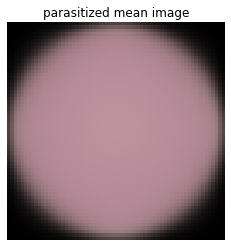

In [ ]:
find_mean_img(parasitized_imgs, 'parasitized mean image')

<b> Mean image for uninfected

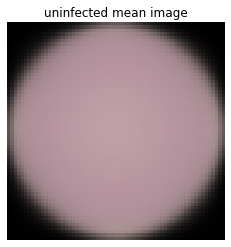

In [ ]:
find_mean_img(uninfected_imgs, 'uninfected mean image')

####<b> Observations and insights:</b>
*   Parasitized cells mean image and uninfected cells mean are both are circular and the same size indicating that the distribution of cell shape are similar in parasitized and uninfected cells
*   Parasitized cells mean image is of a darker shade than uninfected cells mean image, this may be due to parasitized cells having dark purple dots on them, as the dots occur in random locations in the cells, averaging all the parasitized cell images averages out the dots, causing the darker lilac color in parasitized mean image compared to uninfected mean image



### <b>Converting RGB to HSV of Images using OpenCV

###<b> Converting the train data

In [5]:
#return a new array containing arr of hsv converted images
def hsv_convert(arr):

  hsv_arr = []

  for i in np.arange(0, arr.shape[0], 1):
    hsv_image = cv2.cvtColor(arr[i], cv2.COLOR_BGR2HSV)
    hsv_arr.append(hsv_image)

  hsv_arr = np.array(hsv_arr)
  return hsv_arr

In [6]:
#return normalize hsv image array (given input array is a float type)
def normalize_hsv(arr):
  normalized = []

  for i in np.arange(0, arr.shape[0], 1):
    img = arr[i].copy()

    img[:,:,0] = (img[:,:,0]/180.0).astype('float32')
    img[:,:,1] = (img[:,:,1]/255.0).astype('float32')
    img[:,:,2] = (img[:,:,2]/255.0).astype('float32')


    normalized.append(img)

  normalized = np.array(normalized)
  return normalized

In [ ]:
hsv_train_images = hsv_convert(train_images)

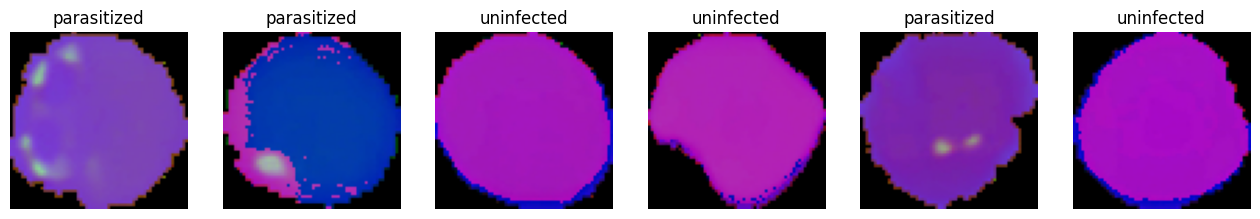

In [ ]:
plot_images(1,6,16,hsv_train_images,train_labels)

In [ ]:
hsv_train_images=hsv_train_images.astype(float)
norm_hsv_train_images = normalize_hsv(hsv_train_images)

###<b> Converting the test data

In [ ]:
hsv_test_images = hsv_convert(test_images)

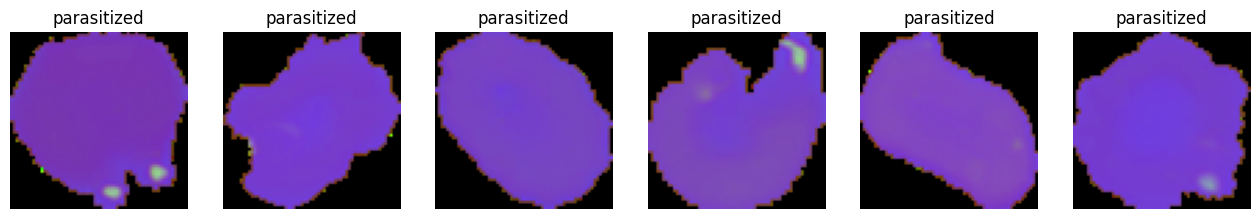

In [ ]:
plot_images(1,6,16,hsv_test_images,train_labels)

In [ ]:
hsv_test_images=hsv_test_images.astype(float)
norm_hsv_test_images = normalize_hsv(hsv_test_images)

####<b>Observations and insights:</b>
*   The above shows the results of the conversion of RGB images to HSV images (Hue, Saturation, Value), Hue is the dominant color observed by humans, Saturation is the amount of white light assorted with hue and Value is the brightness/intensity
*   The dominant color of the cell in these images is purple 
*   In some images, some pixels in the cell have blue as the dominant color, resulting in blotches of blue color, as show in the most right image above
*   The parasitic dot(s) in parasitized cell images show up clearly as yellow/green hue which is slightly easier to detect with human eye
*   Conversion of RGB images to HSV may allow CNNs to learn faster and is a good choice for some computer-vision applications as it separates brightness from color

###<b> Processing Images using Gaussian Blurring

###<b> Gaussian Blurring on train data

In [7]:
#return a new array containing arr of gb converted images
def gb_convert(arr):

  gb_array = []

  for i in np.arange(0, arr.shape[0], 1):
    gb_image = cv2.GaussianBlur(arr[i], (5, 5), 0)
    gb_array.append(gb_image)

  gb_array = np.array(gb_array)
  return gb_array

In [ ]:
gb_train_data = gb_convert(norm_train_images)

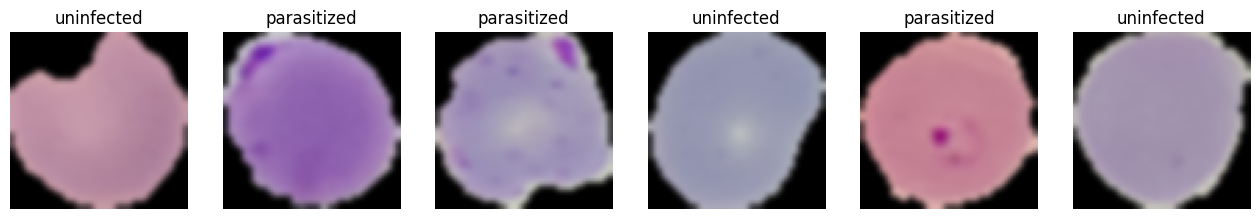

In [ ]:
plot_images(1,6,16,gb_train_data,train_labels)

###<b> Gaussian Blurring on test data

In [ ]:
gb_test_data = gb_convert(norm_test_images)

####**Observations and insights:**
*   Gaussian blurring is a type of image processing using Guassian function to blur an image and reduce noise and speckles
*   After applying Gaussian blurring to the images, the cells appeared to be more blurry compared to the original images with some of the 'noise' in the images removed (i.e. the most right image shown above of an uninfected cell which may have been misclassified as parasitized cell due to a small purple dot 'noise' being smoothed out by the Gaussian blur)

###<b> Gaussian blur followed by HSV

In [ ]:
#train data
gb_train_data_notnorm = gb_convert(train_images)
gb_hsv_train_images = hsv_convert(gb_train_data_notnorm)

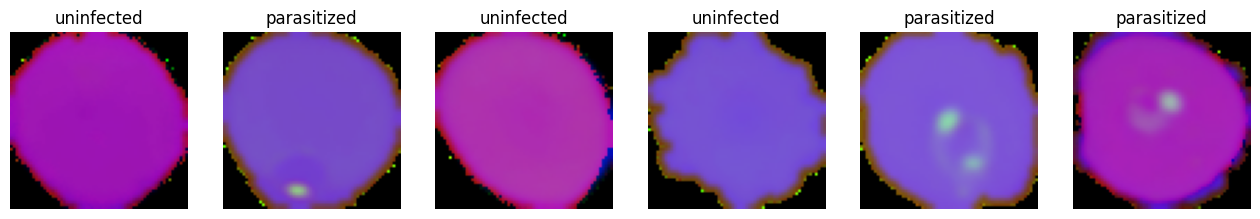

In [ ]:
#plot train data
plot_images(1,6,16,gb_hsv_train_images,train_labels)

In [ ]:
#normalize train data
gb_hsv_train_images=gb_hsv_train_images.astype(float)
norm_hsv_gb_train_images = normalize_hsv(gb_hsv_train_images)

In [ ]:
#test data
gb_test_data_notnorm = gb_convert(test_images)
gb_hsv_test_images = hsv_convert(gb_test_data_notnorm)

In [ ]:
#normalize test data
gb_hsv_test_images=gb_hsv_test_images.astype(float)
norm_hsv_gb_test_images = normalize_hsv(gb_hsv_test_images)

####<b>Observations and insights:</b>
*   Applying Gaussian blur before converting the images into HSV images may help smooth out the picture and remove noises (including the ones that caused dark blue blotches in HSV images without Gaussian blur applied), allowing only the crucial information (the parasitic dots in the cell) to be passed on
*   Other image processing like Laplacian or Sobel edge detector to highlight regions of rapid intensity change (i.e. edge detection) after Guassian is applied to the image may be able to help detect the edges of the purple dots of parasitized cells from from uninfected cells better and help reduce misclassification of both parasitized and uninfected cells

###<b> LaPlacian attempt on greyscale train data and visualization

In [ ]:
#creating function to plot grey scale images taking in 5 arguments (as the plot_images expect BGR format, causing visualization issues)
def plot_greyscale_images(x,y, size, pic_arr,label_arr):
  number_pic=x*y
  number_pic=number_pic+1
  picture_index_arr = random.sample(range(pic_arr.shape[0]-1), number_pic)
  plt.figure(1, figsize = (size , size))
  for n in range(1, number_pic):
    plt.subplot(x,y,n)
    img = pic_arr[picture_index_arr[n]]
    plt.imshow(pic_arr[picture_index_arr[n]], cmap='gray', vmin = 0, vmax = 255)
    if label_arr[picture_index_arr[n]] == 1: 
        plt.title('parasitized')
    else:
        plt.title('uninfected')
    plt.axis('off')

In [ ]:
laPlacianonGB_train_data = []

for i in np.arange(0, norm_train_images.shape[0], 1):
  b = cv2.GaussianBlur(train_images[i], (1, 1), 0)
  src_gray = cv2.cvtColor(b, cv2.COLOR_BGR2GRAY)
  dst = cv2.Laplacian(src_gray, cv2.CV_16S, ksize=1)
  laPlacianonGB_train_data.append(dst)

laPlacianonGB_train_data = np.array(laPlacianonGB_train_data)

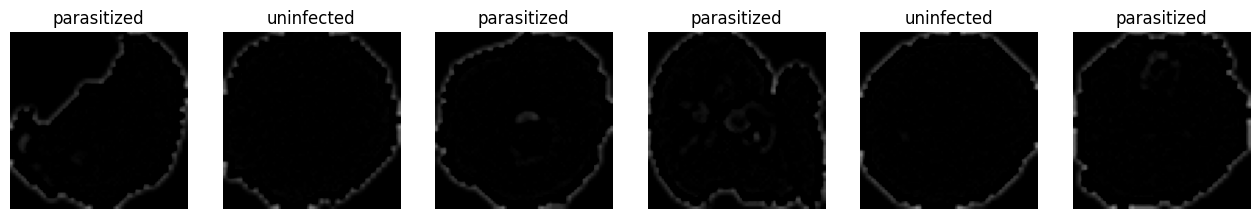

In [ ]:
plot_greyscale_images(1,6,16,gb_train_data,train_labels)

####**Observations and insights:**
Laplacian is used for edge detection, highlighting regions of rapid intensity change. Here Laplacian is applied to cell images after Gaussian Blur which reduced noise in the images. We can see that:
*   The outline of cell in the images are clearly define
*   The outline of previously purple dots unique to parasitized cells shows up faintly
*   The white faint large circle seen in some ofparasitized and uninfected cells which may cause some misclassification was treated as noise and no longer show up in these cell images

Applying image processing technique to the CNN dataset to removes noise and highlight features distinct to parasitized cells can enhance the accuracy of the classification which is attempted here.

It is possible that with further work, we can enhance the edge detection to better detect parasites and haemozoin which will increase the accuracy of models.


## **Model Building**

###<b> Importing the required libraries for building and training our Model

In [6]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout  
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from random import shuffle
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve
from sklearn.metrics import classification_report
from tensorflow.keras.utils import plot_model
from sklearn import model_selection, datasets
from sklearn.tree import DecisionTreeClassifier
import tensorflow as tf

In [7]:
np.random.seed(42)

In [8]:
# function to show metrics score
def metrics_score(actual, predicted):
    cm = confusion_matrix(actual, predicted)
    plt.figure(figsize = (8, 5))
    sns.heatmap(cm, annot = True, fmt = '.2f', xticklabels = ['uninfected', 'paracitisized'], yticklabels = ['uninfected', 'paracitisized'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted') 
    plt.show() 

In [9]:
# function to plot accuracy
def plot_history(history):
    N = len(history.history["accuracy"])
    plt.figure()
    plt.plot(np.arange(0, N), history.history["accuracy"], label="train_accuracy")
    plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_accuracy")
    plt.title("Training accuracy Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("accuracy")
    plt.legend(loc="upper right")

In [10]:
# function to plot loss
def plot_loss(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['Train', 'Validation'], loc='upper right')
  plt.show()

####<B>One Hot Encoding the train and test labels

In [11]:
train_labels_encoded = to_categorical(train_labels, 2)
test_labels_encoded = to_categorical(test_labels, 2)

###<b> Simple Model
**Note:** This model is without dropout and will be extended to make base model

In [ ]:
cnn_simple_model = Sequential()
cnn_simple_model.add(Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))
cnn_simple_model.add(MaxPooling2D())
cnn_simple_model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
cnn_simple_model.add(MaxPooling2D())
cnn_simple_model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
cnn_simple_model.add(Flatten())
cnn_simple_model.add(Dense(128, activation='relu'))
cnn_simple_model.add(Dense(2, activation='softmax'))

In [ ]:
cnn_simple_model.compile(loss="binary_crossentropy", optimizer="adam", metrics = ['accuracy'])
cnn_simple_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 16384)             0

In [ ]:
# no callback implemented to demonstrate overfitting in data
history_cnn_simple_model_test = cnn_simple_model.fit(norm_train_images, train_labels_encoded, epochs= 20, validation_split = 0.2, batch_size = 32, verbose = 1)

Epoch 1/20
624/624 [==============================] - 5s 8ms/step - loss: 0.0309 - accuracy: 0.9887 - val_loss: 0.1146 - val_accuracy: 0.9665
Epoch 2/20
624/624 [==============================] - 5s 7ms/step - loss: 0.0230 - accuracy: 0.9916 - val_loss: 0.1279 - val_accuracy: 0.9688
Epoch 3/20
624/624 [==============================] - 5s 8ms/step - loss: 0.0167 - accuracy: 0.9945 - val_loss: 0.1239 - val_accuracy: 0.9726
Epoch 4/20
624/624 [==============================] - 4s 7ms/step - loss: 0.0155 - accuracy: 0.9943 - val_loss: 0.1136 - val_accuracy: 0.9752
Epoch 5/20
624/624 [==============================] - 5s 7ms/step - loss: 0.0117 - accuracy: 0.9964 - val_loss: 0.1313 - val_accuracy: 0.9752
Epoch 6/20
624/624 [==============================] - 5s 8ms/step - loss: 0.0113 - accuracy: 0.9961 - val_loss: 0.2020 - val_accuracy: 0.9617
Epoch 7/20
624/624 [==============================] - 4s 7ms/step - loss: 0.0069 - accuracy: 0.9981 - val_loss: 0.2422 - val_accuracy: 0.9525
Epoch 

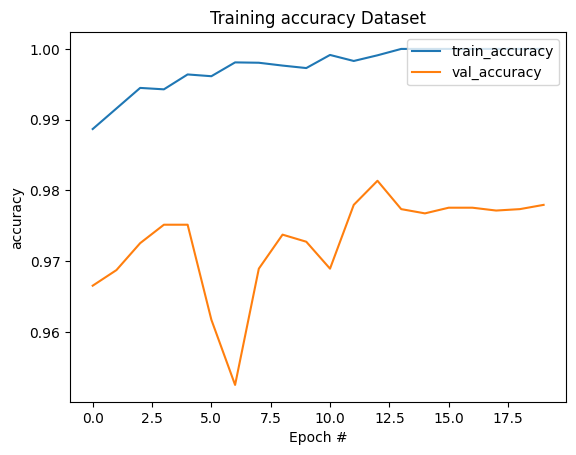

In [ ]:
plot_history(history_cnn_simple_model_test)

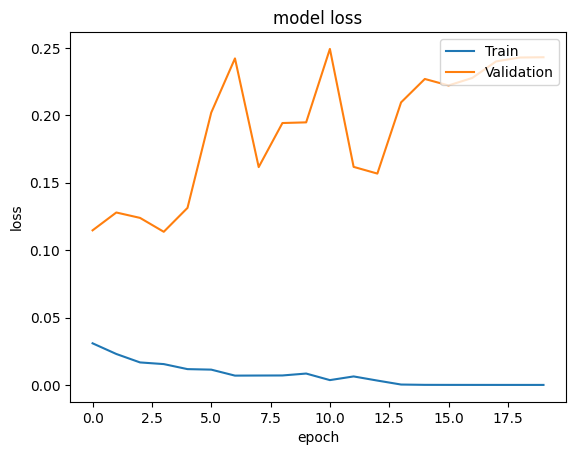

In [ ]:
plot_loss(history_cnn_simple_model_test)

In [ ]:
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 2), ModelCheckpoint('.mdl_wts.hdf5', monitor = 'val_loss', save_best_only = True)]

In [ ]:
# with callback implemented
history_cnn_simple_model = cnn_simple_model.fit(norm_train_images, train_labels_encoded, batch_size = 32, callbacks = callbacks, validation_split = 0.2, epochs = 20, verbose = 1)

Epoch 1/20
624/624 [==============================] - 6s 9ms/step - loss: 0.0463 - accuracy: 0.9842 - val_loss: 0.0485 - val_accuracy: 0.9878
Epoch 2/20
624/624 [==============================] - 5s 7ms/step - loss: 0.0397 - accuracy: 0.9858 - val_loss: 0.1169 - val_accuracy: 0.9663
Epoch 3/20
624/624 [==============================] - 4s 7ms/step - loss: 0.0348 - accuracy: 0.9874 - val_loss: 0.0583 - val_accuracy: 0.9852


In [ ]:
accuracy_cnn_simple_model = cnn_simple_model.evaluate(norm_test_images, test_labels_encoded, verbose = 1)
accuracy_cnn_simple_model

82/82 [==============================] - 1s 8ms/step - loss: 0.0716 - accuracy: 0.9827


[0.07158618420362473, 0.982692301273346]

In [ ]:
pred_cnn_simple_model = cnn_simple_model.predict(norm_test_images)
pred_cnn_simple_model = np.argmax(pred_cnn_simple_model, axis = 1) 
y_true_cnn_simple_model = np.argmax(test_labels_encoded, axis = 1)
# Printing the classification report
print(classification_report(y_true_cnn_simple_model, pred_cnn_simple_model))

82/82 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1300
           1       0.98      0.98      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



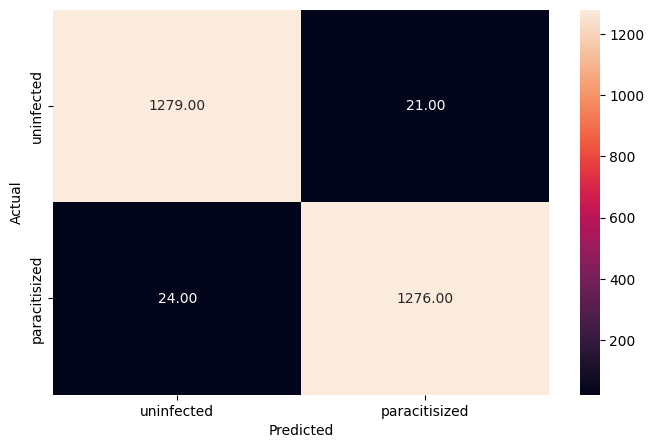

In [ ]:
metrics_score(y_true_cnn_simple_model, pred_cnn_simple_model)

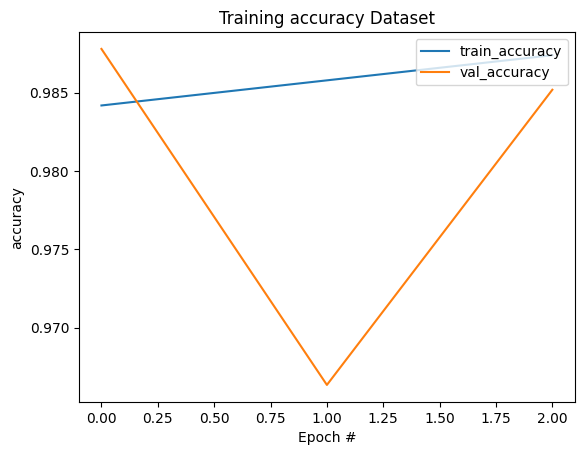

In [ ]:
plot_history(history_cnn_simple_model)

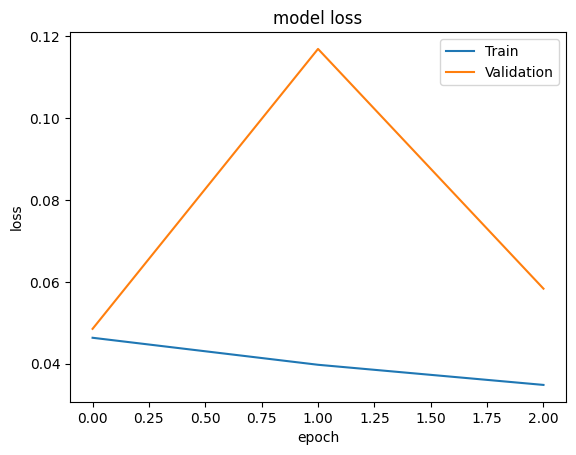

In [ ]:
plot_loss(history_cnn_simple_model)

### **Base Model**

**Note:** The Base Model has been  built and evaluated to give an idea about the process of the creation and evaluation of the performance of a CNN architecture. It lacks dropout and normalizing layers which cause it to be more prune to overfit as seen in accuracy vs epoch plot showing train accuracy continue to increase despite validation accuracy leveling off

###<b> Building the model

In [ ]:
backend.clear_session()

In [14]:
np.random.seed(42)

In [ ]:
cnn_base_model = Sequential()

cnn_base_model.add(Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))
cnn_base_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_base_model.add(Dropout(0.25))

cnn_base_model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
cnn_base_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_base_model.add(Dropout(0.25))

cnn_base_model.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
cnn_base_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_base_model.add(Dropout(0.25))

cnn_base_model.add(Flatten())
cnn_base_model.add(Dense(512, activation='relu'))
cnn_base_model.add(Dropout(0.5))

cnn_base_model.add(Dense(2, activation='softmax'))

#plot_model(cnn_base_model, show_shapes=True)

###<b> Compiling the model

In [ ]:
cnn_base_model.compile(loss="binary_crossentropy", optimizer="adam", metrics = ['accuracy'])
cnn_base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 64)        0

<b> Using Callbacks 

In [ ]:
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 2), ModelCheckpoint('.mdl_wts.hdf5', monitor = 'val_loss', save_best_only = True)]

<b> Fit and train our Model

In [ ]:
# cnn_base_model_norm_rgb
history_base_model_rgb_fit = cnn_base_model.fit(norm_train_images, train_labels_encoded, batch_size = 32, callbacks = callbacks, validation_split = 0.2, epochs = 20, verbose = 1)

Epoch 1/20
624/624 [==============================] - 23s 15ms/step - loss: 0.4194 - accuracy: 0.7849 - val_loss: 0.0700 - val_accuracy: 0.9930
Epoch 2/20
624/624 [==============================] - 6s 10ms/step - loss: 0.1091 - accuracy: 0.9649 - val_loss: 0.0968 - val_accuracy: 0.9894
Epoch 3/20
624/624 [==============================] - 7s 11ms/step - loss: 0.0868 - accuracy: 0.9710 - val_loss: 0.0600 - val_accuracy: 0.9880
Epoch 4/20
624/624 [==============================] - 6s 10ms/step - loss: 0.0779 - accuracy: 0.9735 - val_loss: 0.0845 - val_accuracy: 0.9822
Epoch 5/20
624/624 [==============================] - 6s 10ms/step - loss: 0.0688 - accuracy: 0.9766 - val_loss: 0.0539 - val_accuracy: 0.9858
Epoch 6/20
624/624 [==============================] - 6s 9ms/step - loss: 0.0658 - accuracy: 0.9773 - val_loss: 0.0541 - val_accuracy: 0.9848
Epoch 7/20
624/624 [==============================] - 6s 10ms/step - loss: 0.0665 - accuracy: 0.9775 - val_loss: 0.0796 - val_accuracy: 0.9794

In [ ]:
#cnn_base_model_norm_hsv
history_base_model_hsv_fit = cnn_base_model.fit(norm_hsv_train_images, train_labels_encoded, batch_size = 32, callbacks = callbacks, validation_split = 0.2, epochs = 20, verbose = 1)

Epoch 1/20
624/624 [==============================] - 7s 10ms/step - loss: 0.5664 - accuracy: 0.7182 - val_loss: 0.2550 - val_accuracy: 0.9475
Epoch 2/20
624/624 [==============================] - 5s 9ms/step - loss: 0.1325 - accuracy: 0.9558 - val_loss: 0.1509 - val_accuracy: 0.9882
Epoch 3/20
624/624 [==============================] - 5s 9ms/step - loss: 0.0970 - accuracy: 0.9680 - val_loss: 0.0641 - val_accuracy: 0.9884
Epoch 4/20
624/624 [==============================] - 5s 9ms/step - loss: 0.0824 - accuracy: 0.9728 - val_loss: 0.0493 - val_accuracy: 0.9906
Epoch 5/20
624/624 [==============================] - 5s 9ms/step - loss: 0.0776 - accuracy: 0.9737 - val_loss: 0.0478 - val_accuracy: 0.9912
Epoch 6/20
624/624 [==============================] - 5s 8ms/step - loss: 0.0757 - accuracy: 0.9746 - val_loss: 0.0564 - val_accuracy: 0.9876
Epoch 7/20
624/624 [==============================] - 6s 9ms/step - loss: 0.0706 - accuracy: 0.9756 - val_loss: 0.0381 - val_accuracy: 0.9904
Epoch

In [ ]:
# cnn_base_model_hsv_gb
history_base_model_hsv_gb_fit = cnn_base_model.fit(norm_hsv_gb_train_images, train_labels_encoded, batch_size = 32, callbacks = callbacks, validation_split = 0.2, epochs = 20, verbose = 1)

Epoch 1/20
624/624 [==============================] - 27s 17ms/step - loss: 0.2900 - accuracy: 0.8639 - val_loss: 0.0771 - val_accuracy: 0.9928
Epoch 2/20
624/624 [==============================] - 6s 10ms/step - loss: 0.0978 - accuracy: 0.9677 - val_loss: 0.0638 - val_accuracy: 0.9910
Epoch 3/20
624/624 [==============================] - 7s 11ms/step - loss: 0.0823 - accuracy: 0.9734 - val_loss: 0.0500 - val_accuracy: 0.9916
Epoch 4/20
624/624 [==============================] - 6s 10ms/step - loss: 0.0760 - accuracy: 0.9744 - val_loss: 0.0487 - val_accuracy: 0.9912
Epoch 5/20
624/624 [==============================] - 7s 11ms/step - loss: 0.0716 - accuracy: 0.9766 - val_loss: 0.0393 - val_accuracy: 0.9894
Epoch 6/20
624/624 [==============================] - 6s 9ms/step - loss: 0.0669 - accuracy: 0.9776 - val_loss: 0.0511 - val_accuracy: 0.9884
Epoch 7/20
624/624 [==============================] - 6s 10ms/step - loss: 0.0647 - accuracy: 0.9781 - val_loss: 0.0530 - val_accuracy: 0.9898

In [ ]:
# saving the best performing model in the notebook
cnn_base_model.save('/content/drive/My Drive/Colab Notebooks/saved_models/cnn_base_model_norm_hsv_gb') 

###<b> Evaluating the model on test data

In [ ]:
#cnn_base_model_norm_rgb
accuracy_cnn_base_model_rgb = cnn_base_model.evaluate(norm_test_images, test_labels_encoded, verbose = 1)
accuracy_cnn_base_model_rgb

82/82 [==============================] - 1s 7ms/step - loss: 0.0498 - accuracy: 0.9831


[0.04978816583752632, 0.9830769300460815]

In [ ]:
#cnn_base_model_norm_hsv
accuracy_cnn_base_model_hsv = cnn_base_model.evaluate(norm_hsv_test_images, test_labels_encoded, verbose = 1)
accuracy_cnn_base_model_hsv

82/82 [==============================] - 1s 5ms/step - loss: 0.0535 - accuracy: 0.9835


[0.05353295058012009, 0.9834615588188171]

In [ ]:
#cnn_base_model_norm_hsv_gb
accuracy_cnn_base_model_hsv_gb = cnn_base_model.evaluate(norm_hsv_gb_test_images, test_labels_encoded, verbose = 1)
accuracy_cnn_base_model_hsv_gb

82/82 [==============================] - 1s 8ms/step - loss: 0.0545 - accuracy: 0.9862


[0.054453425109386444, 0.9861538410186768]

<b> Plotting the confusion matrix

In [ ]:
#cnn_base_model_norm_rgb
pred_cnn_base_model_rgb = cnn_base_model.predict(norm_test_images)
pred_cnn_base_model_rgb = np.argmax(pred_cnn_base_model_rgb, axis = 1) 
y_true_cnn_base_model_rgb = np.argmax(test_labels_encoded, axis = 1)
# Printing the classification report
print(classification_report(y_true_cnn_base_model_rgb, pred_cnn_base_model_rgb))

82/82 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1300
           1       0.98      0.99      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



In [ ]:
#cnn_base_model_norm_hsv
pred_cnn_base_model_hsv = cnn_base_model.predict(norm_hsv_test_images)
pred_cnn_base_model_hsv = np.argmax(pred_cnn_base_model_hsv, axis = 1) 
y_true_cnn_base_model_hsv = np.argmax(test_labels_encoded, axis = 1)
# Printing the classification report
print(classification_report(y_true_cnn_base_model_hsv, pred_cnn_base_model_hsv))

82/82 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1300
           1       0.98      0.98      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



In [ ]:
#cnn_base_model_norm_hsv_gb
pred_cnn_base_model_hsv_gb = cnn_base_model.predict(norm_hsv_gb_test_images)
pred_cnn_base_model_hsv_gb = np.argmax(pred_cnn_base_model_hsv_gb, axis = 1) 
y_true_cnn_base_model_hsv_gb = np.argmax(test_labels_encoded, axis = 1)
# Printing the classification report
print(classification_report(y_true_cnn_base_model_hsv_gb, pred_cnn_base_model_hsv_gb))

82/82 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1300
           1       0.99      0.99      0.99      1300

    accuracy                           0.99      2600
   macro avg       0.99      0.99      0.99      2600
weighted avg       0.99      0.99      0.99      2600



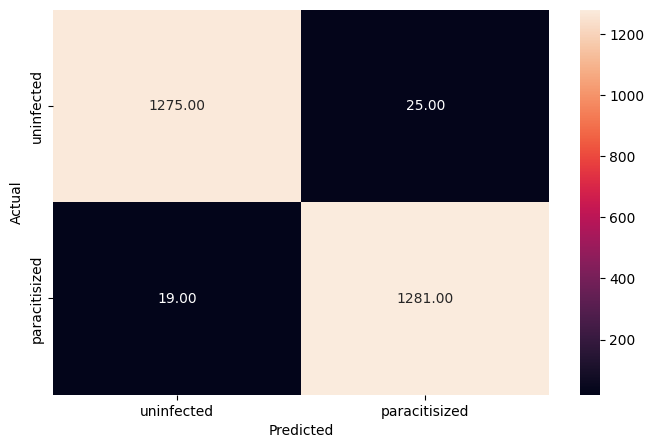

In [ ]:
#cnn_base_model_norm_rgb
metrics_score(y_true_cnn_base_model_rgb, pred_cnn_base_model_rgb)

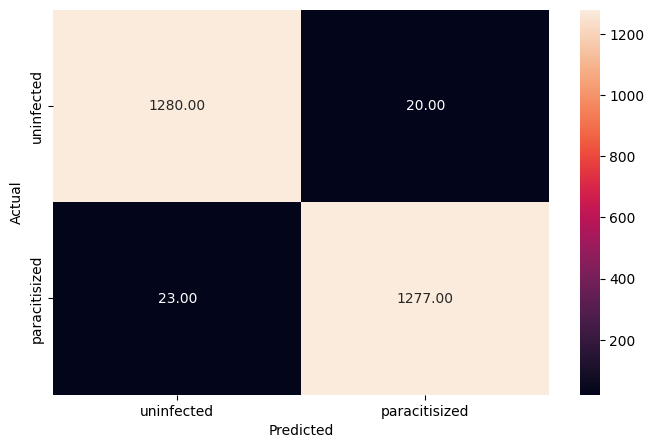

In [ ]:
#cnn_base_model_norm_hsv
metrics_score(y_true_cnn_base_model_hsv, pred_cnn_base_model_hsv)

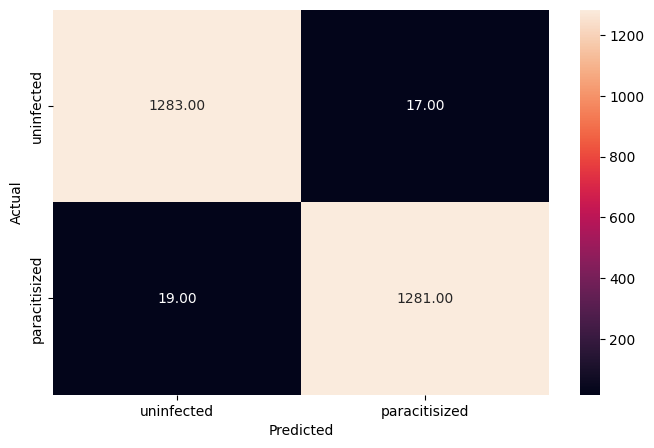

In [ ]:
#cnn_base_model_norm_hsv_gb
metrics_score(y_true_cnn_base_model_hsv_gb, pred_cnn_base_model_hsv_gb)

<b>Plotting the train and validation curves

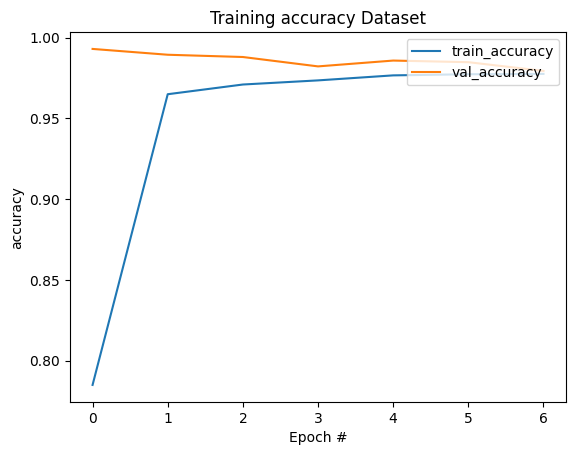

In [ ]:
plot_history(history_base_model_rgb_fit)

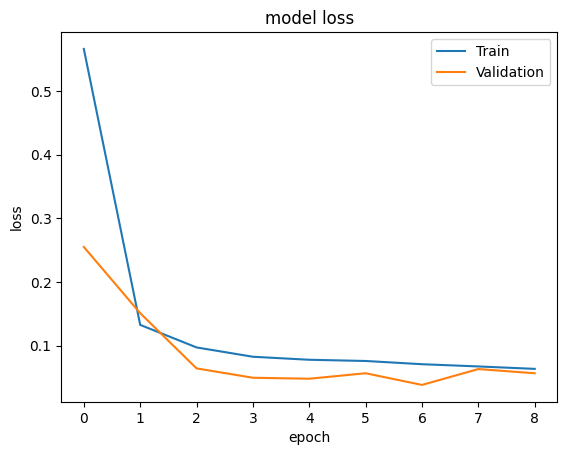

In [ ]:
plot_loss(history_base_model_hsv_fit)

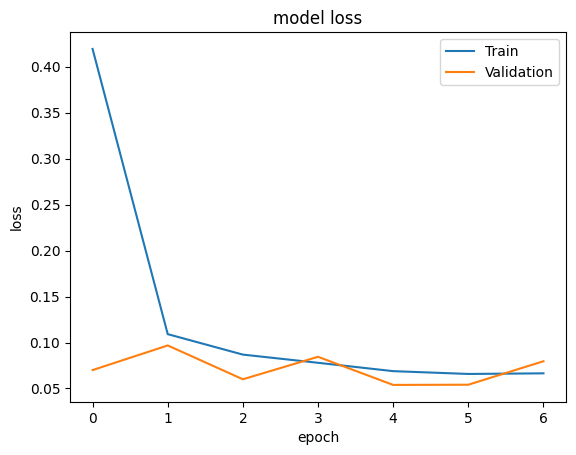

In [ ]:
plot_loss(history_base_model_hsv_gb_fit)

####<b>Observations and insights:</b>
*   Addition of dropout layers results in better generalization and stop the model from overfitting as seen in accuracy vs epoch plot where train accuracy is consistantly lower than validation accuracy with validation accuracy increasing over the epoch


###<b> Model 1
####<b> Trying to improve the performance of our model by adding new layers


In [ ]:
backend.clear_session()

In [ ]:
np.random.seed(42)

In [ ]:
cnn_model_1 = Sequential()

cnn_model_1.add(Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))
cnn_model_1.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model_1.add(Dropout(0.25))

cnn_model_1.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
cnn_model_1.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model_1.add(Dropout(0.25))

cnn_model_1.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
cnn_model_1.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model_1.add(Dropout(0.25))

cnn_model_1.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
cnn_model_1.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model_1.add(Dropout(0.25))

cnn_model_1.add(Conv2D(256, (3, 3), activation='relu', padding="same"))
cnn_model_1.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model_1.add(Dropout(0.25))

cnn_model_1.add(Conv2D(512, (3, 3), activation='relu', padding="same"))
cnn_model_1.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model_1.add(Dropout(0.25))

cnn_model_1.add(Flatten())
cnn_model_1.add(Dense(512, activation='relu'))
cnn_model_1.add(Dropout(0.5))

cnn_model_1.add(Dense(2, activation='softmax'))

###<b> Compiling the model

In [ ]:
cnn_model_1.compile(loss="binary_crossentropy", optimizer="adam", metrics = ['accuracy'])
cnn_model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 64)        0

<b> Using Callbacks

In [ ]:
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 2), ModelCheckpoint('.mdl_wts.hdf5', monitor = 'val_loss', save_best_only = True)]

<b>Fit and Train the model

In [ ]:
#cnn_model_1_model_norm_rgb
history_cnn_model_1_rgb_fit = cnn_model_1.fit(norm_train_images, train_labels_encoded, batch_size = 32, callbacks = callbacks, validation_split = 0.2, epochs = 20, verbose = 1)

Epoch 1/20
624/624 [==============================] - 11s 12ms/step - loss: 0.6147 - accuracy: 0.6524 - val_loss: 0.2595 - val_accuracy: 0.8832
Epoch 2/20
624/624 [==============================] - 6s 10ms/step - loss: 0.1134 - accuracy: 0.9646 - val_loss: 0.1469 - val_accuracy: 0.9531
Epoch 3/20
624/624 [==============================] - 6s 10ms/step - loss: 0.0913 - accuracy: 0.9713 - val_loss: 0.0938 - val_accuracy: 0.9724
Epoch 4/20
624/624 [==============================] - 6s 10ms/step - loss: 0.0888 - accuracy: 0.9739 - val_loss: 0.0647 - val_accuracy: 0.9858
Epoch 5/20
624/624 [==============================] - 7s 10ms/step - loss: 0.0800 - accuracy: 0.9745 - val_loss: 0.0371 - val_accuracy: 0.9878
Epoch 6/20
624/624 [==============================] - 6s 10ms/step - loss: 0.0764 - accuracy: 0.9752 - val_loss: 0.0533 - val_accuracy: 0.9868
Epoch 7/20
624/624 [==============================] - 6s 10ms/step - loss: 0.0723 - accuracy: 0.9770 - val_loss: 0.0587 - val_accuracy: 0.977

In [ ]:
#cnn_model_1_model_norm_hsv
history_cnn_model_1_hsv_fit = cnn_model_1.fit(norm_hsv_train_images, train_labels_encoded, batch_size = 32, callbacks = callbacks, validation_split = 0.2, epochs = 20, verbose = 1)

Epoch 1/20
624/624 [==============================] - 10s 11ms/step - loss: 0.2228 - accuracy: 0.8977 - val_loss: 0.1823 - val_accuracy: 0.9635
Epoch 2/20
624/624 [==============================] - 6s 10ms/step - loss: 0.0817 - accuracy: 0.9751 - val_loss: 0.0705 - val_accuracy: 0.9778
Epoch 3/20
624/624 [==============================] - 6s 10ms/step - loss: 0.0761 - accuracy: 0.9757 - val_loss: 0.0645 - val_accuracy: 0.9796
Epoch 4/20
624/624 [==============================] - 6s 10ms/step - loss: 0.0746 - accuracy: 0.9766 - val_loss: 0.0634 - val_accuracy: 0.9774
Epoch 5/20
624/624 [==============================] - 6s 10ms/step - loss: 0.0740 - accuracy: 0.9770 - val_loss: 0.0421 - val_accuracy: 0.9858
Epoch 6/20
624/624 [==============================] - 7s 11ms/step - loss: 0.0738 - accuracy: 0.9762 - val_loss: 0.0495 - val_accuracy: 0.9840
Epoch 7/20
624/624 [==============================] - 7s 11ms/step - loss: 0.0641 - accuracy: 0.9791 - val_loss: 0.0483 - val_accuracy: 0.983

In [ ]:
#cnn_model_1_model_norm_hsv_gb
history_cnn_model_1_hsv_gb_fit = cnn_model_1.fit(norm_hsv_gb_train_images, train_labels_encoded, batch_size = 32, callbacks = callbacks, validation_split = 0.2, epochs = 20, verbose = 1)

Epoch 1/20
624/624 [==============================] - 7s 11ms/step - loss: 0.4829 - accuracy: 0.7398 - val_loss: 0.1235 - val_accuracy: 0.9792
Epoch 2/20
624/624 [==============================] - 7s 11ms/step - loss: 0.1104 - accuracy: 0.9632 - val_loss: 0.0487 - val_accuracy: 0.9854
Epoch 3/20
624/624 [==============================] - 6s 10ms/step - loss: 0.0865 - accuracy: 0.9711 - val_loss: 0.0627 - val_accuracy: 0.9824
Epoch 4/20
624/624 [==============================] - 6s 10ms/step - loss: 0.0816 - accuracy: 0.9745 - val_loss: 0.0480 - val_accuracy: 0.9872
Epoch 5/20
624/624 [==============================] - 7s 11ms/step - loss: 0.0725 - accuracy: 0.9764 - val_loss: 0.0215 - val_accuracy: 0.9916
Epoch 6/20
624/624 [==============================] - 7s 11ms/step - loss: 0.0766 - accuracy: 0.9757 - val_loss: 0.0302 - val_accuracy: 0.9904
Epoch 7/20
624/624 [==============================] - 6s 10ms/step - loss: 0.0743 - accuracy: 0.9764 - val_loss: 0.0323 - val_accuracy: 0.9902

###<b> Evaluating the model

In [ ]:
#cnn_model_1_model_norm_rgb
accuracy_cnn_model_1_rgb = cnn_model_1.evaluate(norm_test_images, test_labels_encoded, verbose = 1)
accuracy_cnn_model_1_rgb

82/82 [==============================] - 0s 4ms/step - loss: 0.0524 - accuracy: 0.9812


[0.05240660905838013, 0.9811538457870483]

In [ ]:
#cnn_model_1_model_norm_hsv
accuracy_cnn_model_1_hsv = cnn_model_1.evaluate(norm_hsv_test_images, test_labels_encoded, verbose = 1)
accuracy_cnn_model_1_hsv

82/82 [==============================] - 1s 5ms/step - loss: 0.0596 - accuracy: 0.9804


[0.05955680087208748, 0.9803845882415771]

In [ ]:
#cnn_model_1_model_norm_hsv_gb
accuracy_cnn_model_1_hsv_gb = cnn_model_1.evaluate(norm_hsv_gb_test_images, test_labels_encoded, verbose = 1)
accuracy_cnn_model_1_hsv_gb

82/82 [==============================] - 0s 4ms/step - loss: 0.0556 - accuracy: 0.9815


[0.05555232614278793, 0.9815384745597839]

<b> Plotting the confusion matrix

In [ ]:
#cnn_model_1_model_norm_rgb
pred_cnn_model_1_rgb = cnn_model_1.predict(norm_test_images)
pred_cnn_model_1_rgb = np.argmax(pred_cnn_model_1_rgb, axis = 1) 
y_true_cnn_model_1_rgb = np.argmax(test_labels_encoded, axis = 1)
# Printing the classification report
print(classification_report(y_true_cnn_model_1_rgb, pred_cnn_model_1_rgb))

82/82 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1300
           1       0.98      0.99      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



In [ ]:
#cnn_model_1_model_norm_hsv
pred_cnn_model_1_hsv = cnn_model_1.predict(norm_hsv_test_images)
pred_cnn_model_1_hsv = np.argmax(pred_cnn_model_1_hsv, axis = 1) 
y_true_cnn_model_1_hsv = np.argmax(test_labels_encoded, axis = 1)
# Printing the classification report
print(classification_report(y_true_cnn_model_1_hsv, pred_cnn_model_1_hsv))

82/82 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1300
           1       0.98      0.98      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



In [ ]:
#cnn_model_1_model_norm_hsv_gb
pred_cnn_model_1_hsv_gb = cnn_model_1.predict(norm_hsv_gb_test_images)
pred_cnn_model_1_hsv_gb = np.argmax(pred_cnn_model_1_hsv_gb, axis = 1) 
y_true_cnn_model_1_hsv_gb = np.argmax(test_labels_encoded, axis = 1)
# Printing the classification report
print(classification_report(y_true_cnn_model_1_hsv_gb, pred_cnn_model_1_hsv_gb))

82/82 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1300
           1       0.99      0.97      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



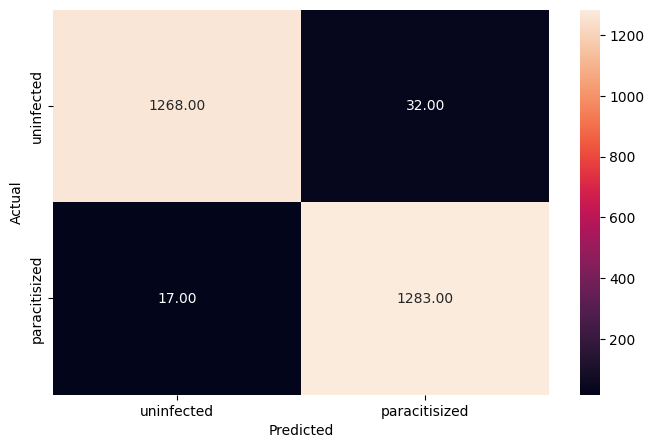

In [ ]:
#cnn_model_1_model_norm_rgb
metrics_score(y_true_cnn_model_1_rgb, pred_cnn_model_1_rgb)

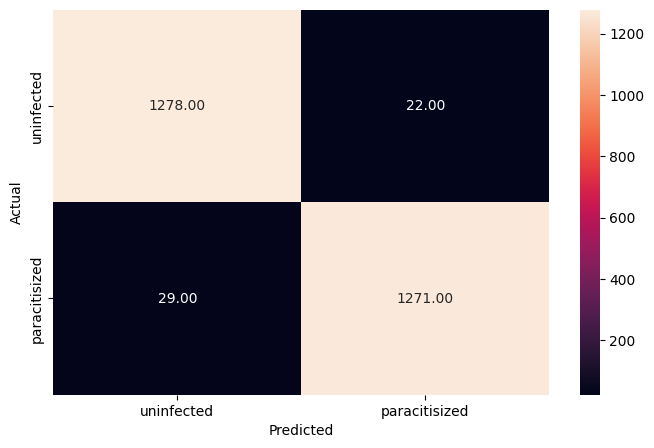

In [ ]:
#cnn_model_1_model_norm_hsv
metrics_score(y_true_cnn_model_1_hsv, pred_cnn_model_1_hsv)

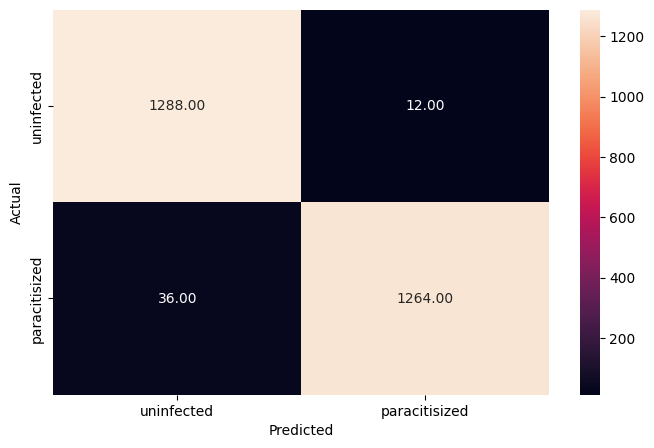

In [ ]:
#cnn_model_1_model_norm_hsv_gb
metrics_score(y_true_cnn_model_1_hsv_gb, pred_cnn_model_1_hsv_gb)

<b> Plotting the train and the validation curves

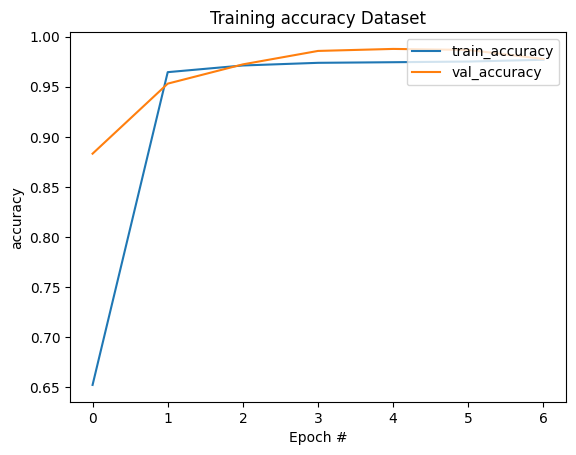

In [ ]:
#cnn_model_1_model_norm_rgb
plot_history(history_cnn_model_1_rgb_fit)

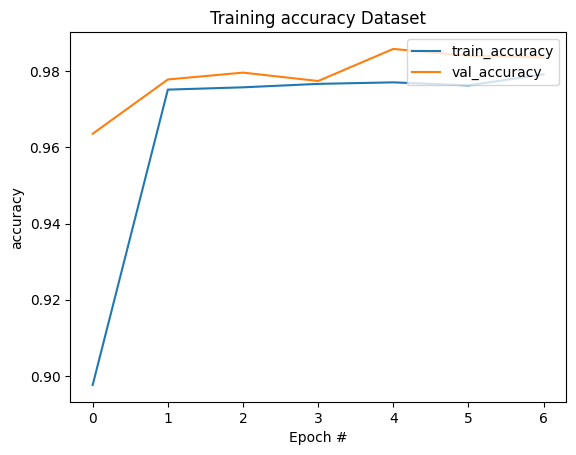

In [ ]:
#cnn_model_1_model_norm_hsv
plot_history(history_cnn_model_1_hsv_fit)

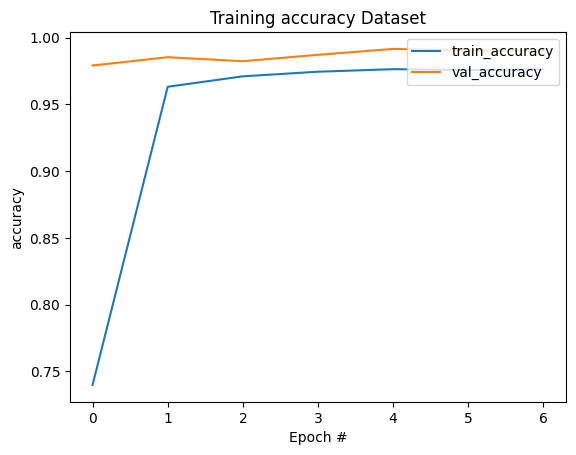

In [ ]:
#cnn_model_1_model_norm_hsv_gb
plot_history(history_cnn_model_1_hsv_gb_fit)

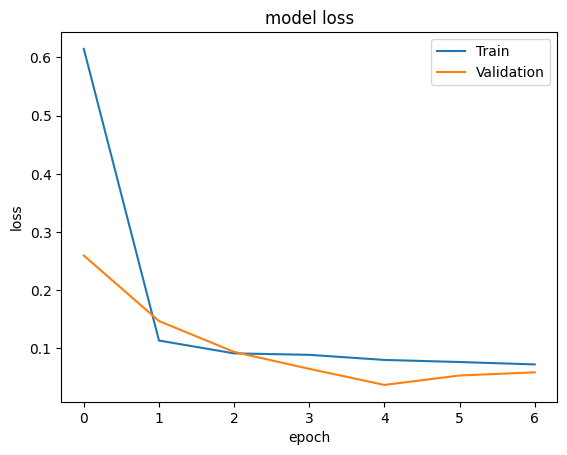

In [ ]:
#cnn_model_1_model_norm_rgb
plot_loss(history_cnn_model_1_rgb_fit)

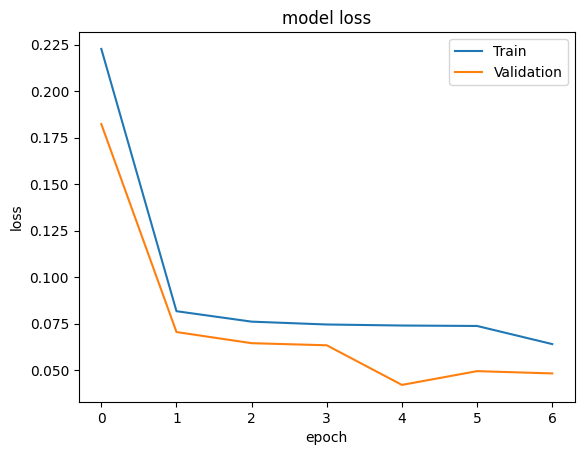

In [ ]:
#cnn_model_1_model_norm_hsv
plot_loss(history_cnn_model_1_hsv_fit)

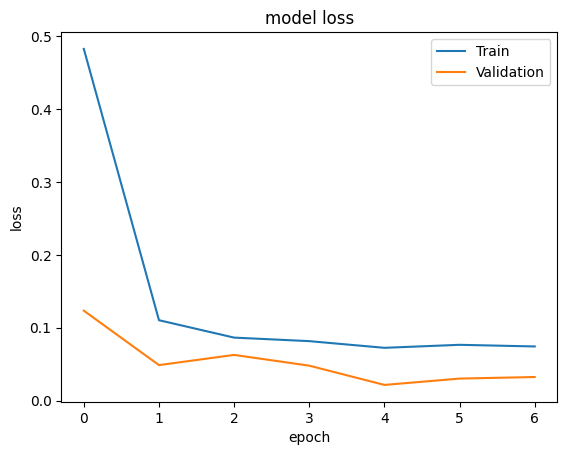

In [ ]:
#cnn_model_1_model_norm_hsv_gb
plot_loss(history_cnn_model_1_hsv_gb_fit)

####<b>Observations and insights:</b>
*   Addition layers were added along with extra maxpooling layers to try to keep the number of trainable parameters low, there is no clear indication that the addition of extra layers helps improve the performance of the model in this case as the model accuracy on test data remains at 98%


###<b> Model 2 with Batch Normalization

#### **Further modification to the original model:**
*  Addition of leaky ReLU functions immediately after convolutional layer to improve non linear representation of the data and attempt to improve the accuracy of the model
*  Addition of BatchNormalization layer to accelerate training process

In [ ]:
backend.clear_session()
np.random.seed(42)

###<b> Building the Model

In [ ]:
cnn_model_2 = Sequential()

cnn_model_2.add(Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))
cnn_model_2.add(LeakyReLU(0.1))
cnn_model_2.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model_2.add(Dropout(0.25))

cnn_model_2.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
cnn_model_2.add(LeakyReLU(0.1))
cnn_model_2.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model_2.add(Dropout(0.25))

cnn_model_2.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
cnn_model_2.add(LeakyReLU(0.1))
cnn_model_2.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model_2.add(BatchNormalization())
cnn_model_2.add(Dropout(0.25))

cnn_model_2.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
cnn_model_2.add(LeakyReLU(0.1))
cnn_model_2.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model_2.add(BatchNormalization())
cnn_model_2.add(Dropout(0.25))

cnn_model_2.add(Conv2D(256, (3, 3), activation='relu', padding="same"))
cnn_model_2.add(LeakyReLU(0.1))
cnn_model_2.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model_2.add(BatchNormalization())
cnn_model_2.add(Dropout(0.25))

cnn_model_2.add(Conv2D(512, (3, 3), activation='relu', padding="same"))
cnn_model_2.add(LeakyReLU(0.1))
cnn_model_2.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model_2.add(BatchNormalization())
cnn_model_2.add(Dropout(0.25))

cnn_model_2.add(Flatten())
cnn_model_2.add(Dense(512, activation='relu'))
cnn_model_2.add(LeakyReLU(0.1))
cnn_model_2.add(Dropout(0.5))
cnn_model_2.add(Dense(2, activation='softmax'))

###<b>Compiling the model

In [ ]:
cnn_model_2.compile(loss="binary_crossentropy", optimizer="adam", metrics = ['accuracy'])
cnn_model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                        

<b> Using callbacks

In [ ]:
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 2), ModelCheckpoint('.mdl_wts.hdf5', monitor = 'val_loss', save_best_only = True)]

<b>Fit and train the model

In [ ]:
#cnn_model_2_model_norm_rgb
history_cnn_model_2_rgb_fit = cnn_model_2.fit(norm_train_images, train_labels_encoded, batch_size = 32, callbacks = callbacks, validation_split = 0.2, epochs = 20, verbose = 1)

Epoch 1/20
624/624 [==============================] - 13s 13ms/step - loss: 0.6911 - accuracy: 0.6503 - val_loss: 0.0629 - val_accuracy: 0.9884
Epoch 2/20
624/624 [==============================] - 7s 12ms/step - loss: 0.1685 - accuracy: 0.9401 - val_loss: 0.0207 - val_accuracy: 0.9970
Epoch 3/20
624/624 [==============================] - 7s 12ms/step - loss: 0.1126 - accuracy: 0.9637 - val_loss: 0.0174 - val_accuracy: 0.9964
Epoch 4/20
624/624 [==============================] - 7s 12ms/step - loss: 0.0978 - accuracy: 0.9680 - val_loss: 0.0389 - val_accuracy: 0.9894
Epoch 5/20
624/624 [==============================] - 8s 13ms/step - loss: 0.0878 - accuracy: 0.9715 - val_loss: 0.0201 - val_accuracy: 0.9932


In [ ]:
#cnn_model_2_model_norm_hsv
history_cnn_model_2_hsv_fit = cnn_model_2.fit(norm_hsv_train_images, train_labels_encoded, batch_size = 32, callbacks = callbacks, validation_split = 0.2, epochs = 20, verbose = 1)

Epoch 1/20
624/624 [==============================] - 8s 13ms/step - loss: 0.0739 - accuracy: 0.9759 - val_loss: 0.0140 - val_accuracy: 0.9952
Epoch 2/20
624/624 [==============================] - 7s 12ms/step - loss: 0.0759 - accuracy: 0.9778 - val_loss: 0.0387 - val_accuracy: 0.9854
Epoch 3/20
624/624 [==============================] - 7s 12ms/step - loss: 0.0698 - accuracy: 0.9772 - val_loss: 0.0132 - val_accuracy: 0.9934
Epoch 4/20
624/624 [==============================] - 7s 12ms/step - loss: 0.0703 - accuracy: 0.9781 - val_loss: 0.0164 - val_accuracy: 0.9934
Epoch 5/20
624/624 [==============================] - 7s 12ms/step - loss: 0.0659 - accuracy: 0.9798 - val_loss: 0.0289 - val_accuracy: 0.9850


In [ ]:
#cnn_model_2_model_norm_hsv_gb
history_cnn_model_2_hsv_gb_fit = cnn_model_2.fit(norm_hsv_gb_train_images, train_labels_encoded, batch_size = 32, callbacks = callbacks, validation_split = 0.2, epochs = 20, verbose = 1)

Epoch 1/20
624/624 [==============================] - 9s 13ms/step - loss: 0.4275 - accuracy: 0.7887 - val_loss: 0.0353 - val_accuracy: 0.9922
Epoch 2/20
624/624 [==============================] - 8s 12ms/step - loss: 0.1001 - accuracy: 0.9682 - val_loss: 0.0405 - val_accuracy: 0.9890
Epoch 3/20
624/624 [==============================] - 8s 12ms/step - loss: 0.0872 - accuracy: 0.9724 - val_loss: 0.0373 - val_accuracy: 0.9866


###<b>Evaluating the model

In [ ]:
#cnn_model_2_model_norm_rgb
accuracy_cnn_model_2_rgb = cnn_model_2.evaluate(norm_test_images, test_labels_encoded, verbose = 1)
accuracy_cnn_model_2_rgb

82/82 [==============================] - 0s 5ms/step - loss: 0.0955 - accuracy: 0.9762


[0.09552396088838577, 0.9761538505554199]

In [ ]:
#cnn_model_2_model_norm_hsv
accuracy_cnn_model_2_hsv = cnn_model_2.evaluate(norm_hsv_test_images, test_labels_encoded, verbose = 1)
accuracy_cnn_model_2_hsv

82/82 [==============================] - 0s 5ms/step - loss: 0.0637 - accuracy: 0.9808


[0.06373699754476547, 0.9807692170143127]

In [ ]:
#cnn_model_2_model_norm_hsv_gb
accuracy_cnn_model_2_hsv_gb = cnn_model_2.evaluate(norm_hsv_gb_test_images, test_labels_encoded, verbose = 1)
accuracy_cnn_model_2_hsv_gb

82/82 [==============================] - 1s 5ms/step - loss: 0.0565 - accuracy: 0.9796


[0.05649866536259651, 0.9796153903007507]

<b> Generate the classification report and confusion matrix 

In [ ]:
#cnn_model_2_model_norm_rgb
pred_cnn_model_2_rgb = cnn_model_2.predict(norm_test_images)
pred_cnn_model_2_rgb = np.argmax(pred_cnn_model_2_rgb, axis = 1) 
y_true_cnn_model_2_rgb = np.argmax(test_labels_encoded, axis = 1)
# Printing the classification report
print(classification_report(y_true_cnn_model_2_rgb, pred_cnn_model_2_rgb))

82/82 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1300
           1       0.99      0.96      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



In [ ]:
#cnn_model_2_model_norm_hsv
pred_cnn_model_2_hsv = cnn_model_2.predict(norm_hsv_test_images)
pred_cnn_model_2_hsv = np.argmax(pred_cnn_model_2_hsv, axis = 1) 
y_true_cnn_model_2_hsv = np.argmax(test_labels_encoded, axis = 1)
# Printing the classification report
print(classification_report(y_true_cnn_model_2_hsv, pred_cnn_model_2_hsv))

82/82 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1300
           1       0.99      0.97      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



In [ ]:
#cnn_model_2_model_norm_hsv_gb
pred_cnn_model_2_hsv_gb = cnn_model_2.predict(norm_hsv_gb_test_images)
pred_cnn_model_2_hsv_gb = np.argmax(pred_cnn_model_2_hsv_gb, axis = 1) 
y_true_cnn_model_2_hsv_gb = np.argmax(test_labels_encoded, axis = 1)
# Printing the classification report
print(classification_report(y_true_cnn_model_2_hsv_gb, pred_cnn_model_2_hsv_gb))

82/82 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1300
           1       0.99      0.97      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



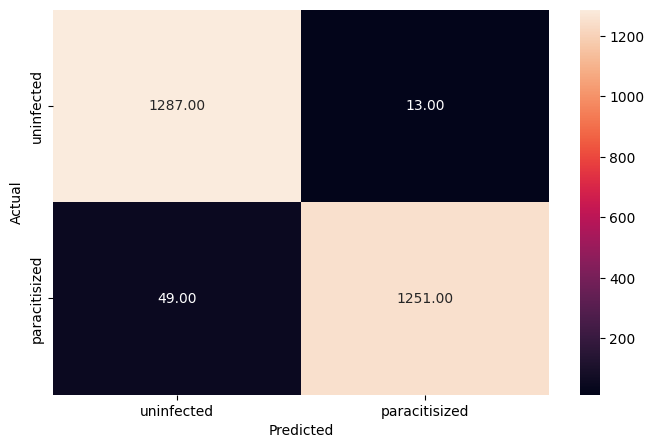

In [ ]:
#cnn_model_2_model_norm_rgb
metrics_score(y_true_cnn_model_2_rgb, pred_cnn_model_2_rgb)

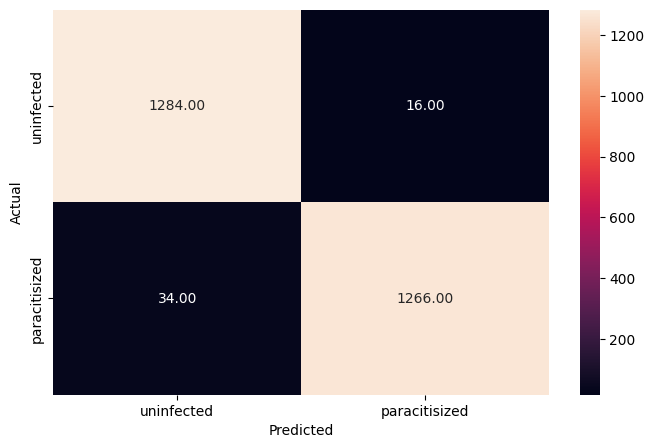

In [ ]:
#cnn_model_2_model_norm_hsv
metrics_score(y_true_cnn_model_2_hsv, pred_cnn_model_2_hsv)

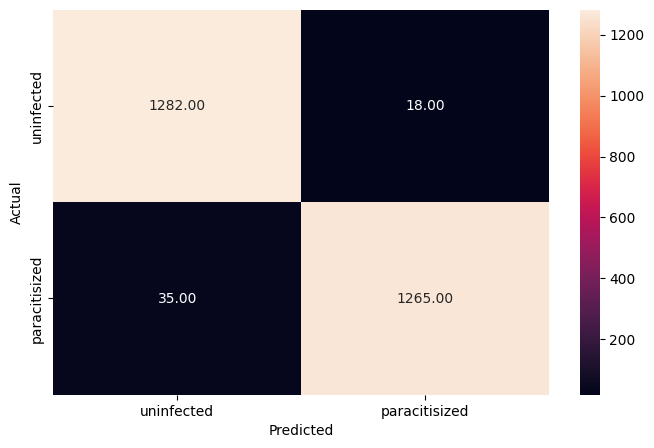

In [ ]:
#cnn_model_2_model_norm_hsv_gb
metrics_score(y_true_cnn_model_2_hsv_gb, pred_cnn_model_2_hsv_gb)

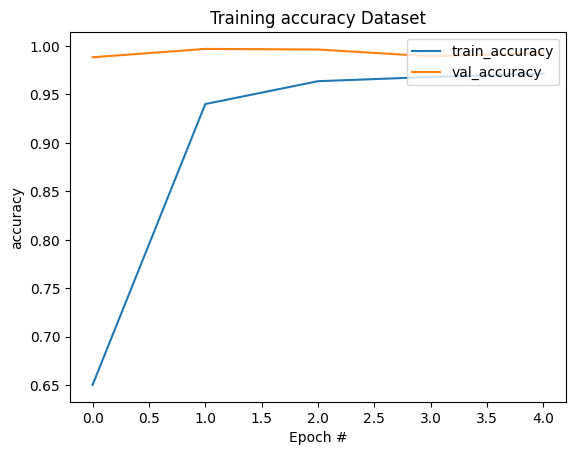

In [ ]:
#cnn_model_2_model_norm_rgb
plot_history(history_cnn_model_2_rgb_fit)

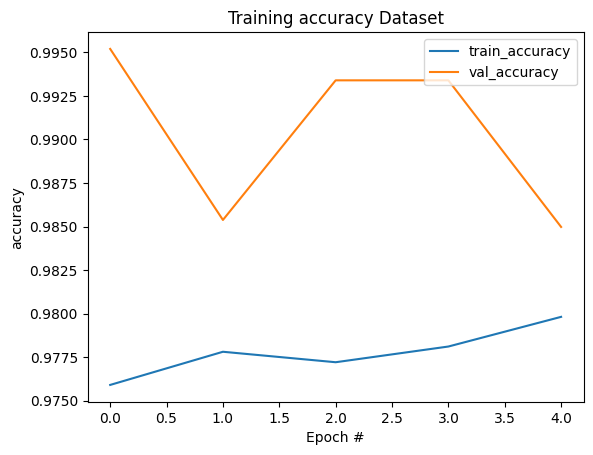

In [ ]:
#cnn_model_2_model_norm_hsv
plot_history(history_cnn_model_2_hsv_fit)

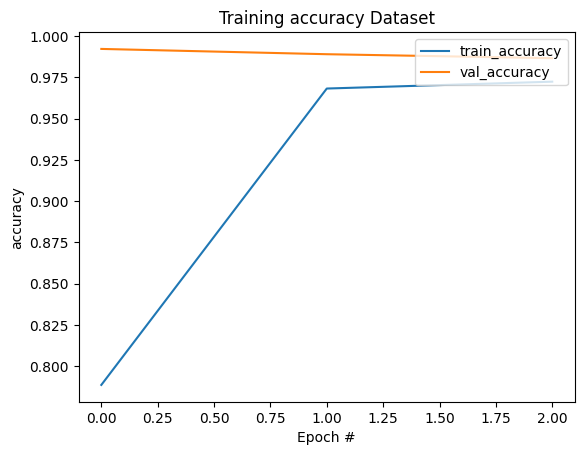

In [ ]:
#cnn_model_2_model_norm_hsv_gb
plot_history(history_cnn_model_2_hsv_gb_fit)

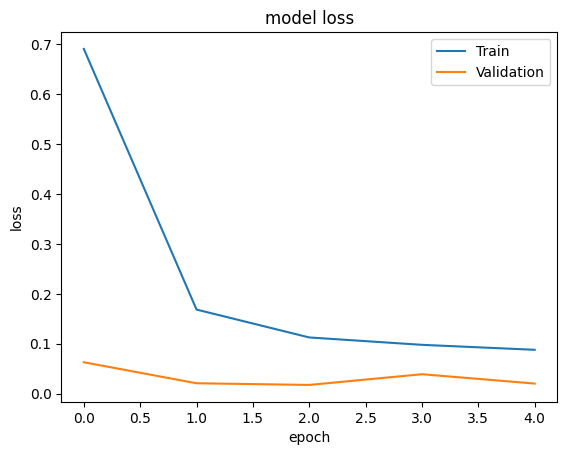

In [ ]:
#cnn_model_2_model_norm_rgb
plot_loss(history_cnn_model_2_rgb_fit)

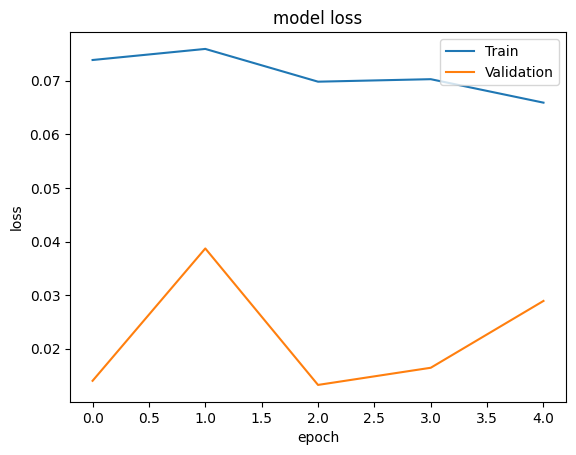

In [ ]:
#cnn_model_2_model_norm_hsv
plot_loss(history_cnn_model_2_hsv_fit)

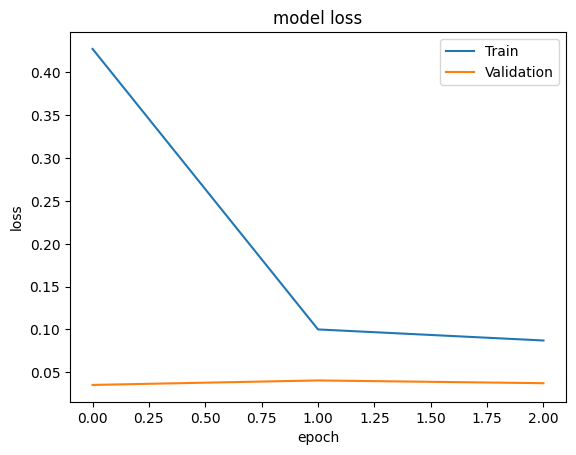

In [ ]:
#cnn_model_2_model_norm_hsv_gb
plot_loss(history_cnn_model_2_hsv_gb_fit)

####<b>Observations and insights:</b>
The simple_model has dropout layer.

Simple_model is modified into base_model by adding more layer and dropouts, we added more layers to base_model to create model_1, using maxpooling to lower number of trainable parameters. Model_1 is modified by changing activation function to Leaky ReLU and adding batch normalization to produce model_2, the observations are as follows:
*   The simple model shows higher accuracy in train data compared to validation and test set, this is due to poorer generalization than other models as there is no dropout layers which is used to randomly drop out fractions of nodes during training (i.e. regularization), therefore showing signs of overfitting
*   Base_model, model_1 and model_2 (with increasing number of dropout layers): 
    *   the 3 models performed similarly well accuracy-wise, with all three having 98% accuracies
    *   recall is the highest for base_model at 99% while model_1 recall is 97% and model_2, 96% - in this case recall is more important than precision as false negatives will result in patients with malaria undetected and not receiving the appropriate treatment
    *   model_2 contains leaky ReLU and batch normalization layers, although these layers can be helpful in preventing dying ReLU problem from occuring, enough regularization methods has been put inplace already and the model architecture is not so deep that the problem would occur and so the addition of these layers may have cause a small decrease in model performance instead of optimizing it further
    *   in conclusion, out of all custom model architectures, model_1 architecture gives the best results possibly due to having the most optimal number of dropout layers allowing it to generalize without sacrificing too much accuracy
    *   Total trainable parameters:
           *   base_model: 4,289,090
           *   model_1: 1,979,842
           *   model_2: 1,981,890

        Base model has the highest number of trainable parameters while model_1 and model_2 have lower number of trainable parameters due to the use of Maxpooling layers - although having a high number of trainable parameters can increase the risk of overfitting the training data and cause the model to have poor generalization, it can help the models learn more complex relationships 
        
        Lowering the number of trainable parameters by using too many maxpooling layers can lead to loss of information, especially in the case of segmentation tasks where maxpooling can lead to loss of important details and features

        In this case, base_model architecture is the most optimal model

###**Think About It :**<br>

* Can we improve the model with Image Data Augmentation?
* References to image data augmentation can be seen below:
  *   [Image Augmentation for Computer Vision](https://www.mygreatlearning.com/blog/understanding-data-augmentation/)
  *   [How to Configure Image Data Augmentation in Keras?](https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/)





###<b>Model 3 with Data Augmentation

In [12]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

###<b> Use image data generator

In [ ]:
backend.clear_session()
np.random.seed(42)

In [13]:
X_train, X_val, y_train, y_val = train_test_split(norm_train_images, train_labels_encoded, test_size = 0.2, random_state = 42)

In [14]:
X_train_visual, X_val_visual, y_train_visual, y_val_visual = train_test_split(norm_train_images, train_labels, test_size = 0.2, random_state = 42)

In [15]:
train_datagen = ImageDataGenerator(horizontal_flip = True, vertical_flip = False, fill_mode = 'constant', zoom_range = 0.1, height_shift_range= 0.1, width_shift_range=0.1, rotation_range = 180)
val_datagen  = ImageDataGenerator()
train_generator = train_datagen.flow(x = X_train, y = y_train, batch_size = 64, seed = 42, shuffle = True)
val_generator =  val_datagen.flow(x = X_val, y = y_val, batch_size = 64, seed = 42, shuffle = True)
train_generator_visual = train_datagen.flow(x = X_train_visual, y = y_train_visual, batch_size = 64, seed = 42, shuffle = True)

In [16]:
train_generator_array = train_datagen.flow(x = norm_train_images, y = train_labels_encoded, batch_size = 64, seed = 42, shuffle = False)

In [17]:
aug_rgb_images=np.concatenate([train_generator_array.next()[0] for i in range(train_generator_array.__len__())])
aug_data_encoded_label=np.concatenate([train_generator_array.next()[1] for i in range(train_generator_array.__len__())])

###**Think About It :**<br>

*  Check if the performance of the model can be improved by changing different parameters in the ImageDataGenerator.



####<B>Visualizing Augmented images

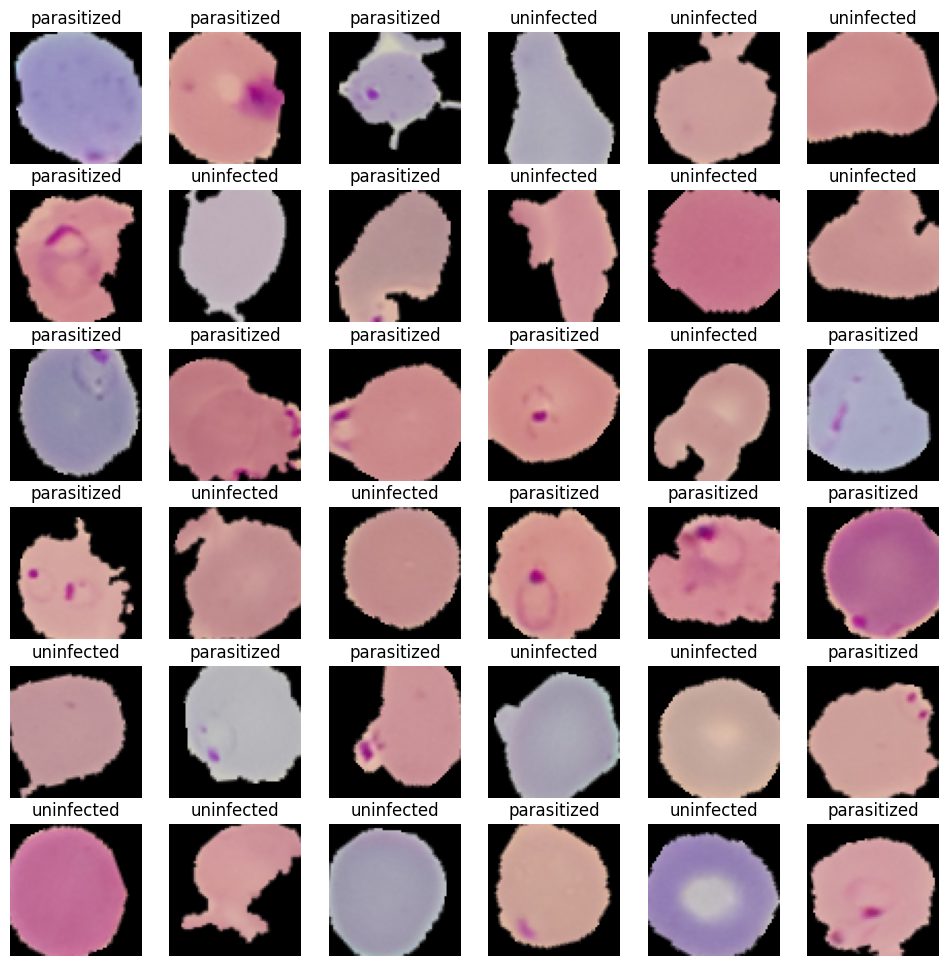

In [ ]:
images, labels = next(train_generator_visual)
fig, axes = plt.subplots(6, 6)

fig.set_size_inches(12, 12)
for (image, label, ax) in zip(images, labels, axes.flatten()):
    ax.imshow(image)
    if label == 1: 
        ax.set_title('parasitized')
    else:
        ax.set_title('uninfected')
    ax.axis('off')

####<b>Observations and insights:</b>
The augmented images show:
*   Flipped and rotated original images
*   `fill_mode = 'constant'` allow us to retain cells original shapes rather than using the default fill mode: `fill_mode = 'nearest'` which cause deformations in the image, lowering accuracy of the model trained using the dataset
*   The images are kept at the nearly the same size as the original images as zooming the pictures too much could cut off the area with the purple dot(s), possibly lowering the accuracy of the model

Insights:
*   The augmented images are essentially original images flipped and rotated which can help train the model better to recognize the variety of position that the purple dot(s) can occur in the cells

###<b>Varify and recreate the best performing model, training it on augmented data

In [55]:
backend.clear_session()
np.random.seed(42)

In [23]:
# we are using the best performing model (model_1), training it on augmented data to check if this will give a better model performance
best_perf_model = Sequential()

best_perf_model.add(Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))
best_perf_model.add(MaxPooling2D(pool_size=(2, 2)))
best_perf_model.add(Dropout(0.25))

best_perf_model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
best_perf_model.add(MaxPooling2D(pool_size=(2, 2)))
best_perf_model.add(Dropout(0.25))

best_perf_model.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
best_perf_model.add(MaxPooling2D(pool_size=(2, 2)))
best_perf_model.add(Dropout(0.25))

best_perf_model.add(Flatten())
best_perf_model.add(Dense(512, activation='relu'))
best_perf_model.add(Dropout(0.5))

best_perf_model.add(Dense(2, activation='softmax'))

# plot_model(cnn_base_model, show_shapes=True)

In [26]:
adam = optimizers.Adam(learning_rate = 0.001)

best_perf_model.compile(loss = "binary_crossentropy", optimizer = adam, metrics = ['accuracy'])
best_perf_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 64)        0

<b>Using Callbacks

In [24]:
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 2), ModelCheckpoint('.mdl_wts.hdf5', monitor = 'val_loss', save_best_only = True)]

<b> Fit and Train the model

In [56]:
history_best_perf_model_aug_rgt_fit = best_perf_model.fit(train_generator, validation_data = val_generator, batch_size = 32, callbacks = callbacks, epochs = 20, verbose = 1)

Epoch 1/20
312/312 [==============================] - 21s 65ms/step - loss: 0.0793 - accuracy: 0.9748 - val_loss: 0.0602 - val_accuracy: 0.9802
Epoch 2/20
312/312 [==============================] - 21s 66ms/step - loss: 0.0765 - accuracy: 0.9759 - val_loss: 0.0579 - val_accuracy: 0.9808
Epoch 3/20
312/312 [==============================] - 20s 65ms/step - loss: 0.0752 - accuracy: 0.9762 - val_loss: 0.0499 - val_accuracy: 0.9802
Epoch 4/20
312/312 [==============================] - 21s 66ms/step - loss: 0.0717 - accuracy: 0.9757 - val_loss: 0.0709 - val_accuracy: 0.9782
Epoch 5/20
312/312 [==============================] - 20s 65ms/step - loss: 0.0781 - accuracy: 0.9750 - val_loss: 0.0633 - val_accuracy: 0.9788


###<B>Evaluating the model

<b>Plot the train and validation accuracy

In [57]:
accuracy_cnn_best_perf_model_aug_rgb = best_perf_model.evaluate(norm_test_images, test_labels_encoded, verbose = 1)
accuracy_cnn_best_perf_model_aug_rgb

82/82 [==============================] - 0s 4ms/step - loss: 0.0492 - accuracy: 0.9808


[0.04917220398783684, 0.9807692170143127]

<B>Plotting the classification report and confusion matrix

In [59]:
pred_cnn_best_perf_model_aug_rgb = best_perf_model.predict(norm_test_images)
pred_cnn_best_perf_model_aug_rgb = np.argmax(pred_cnn_best_perf_model_aug_rgb, axis = 1) 
y_true_cnn_best_perf_model_aug_rgb = np.argmax(test_labels_encoded, axis = 1)
# Printing the classification report
print(classification_report(y_true_cnn_best_perf_model_aug_rgb, pred_cnn_best_perf_model_aug_rgb))

82/82 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1300
           1       0.99      0.97      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



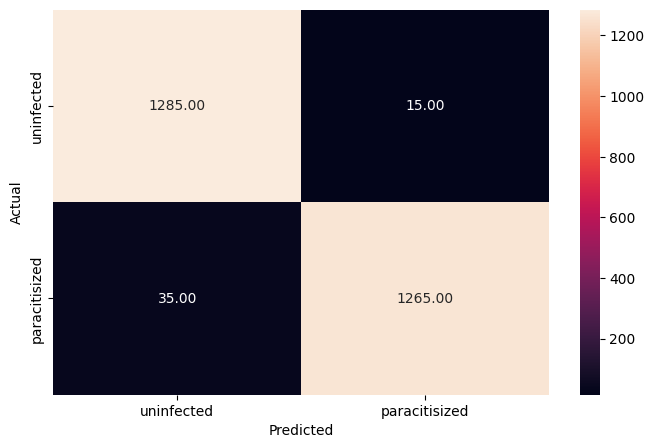

In [21]:
metrics_score(y_true_cnn_best_perf_model_aug_rgb, pred_cnn_best_perf_model_aug_rgb)

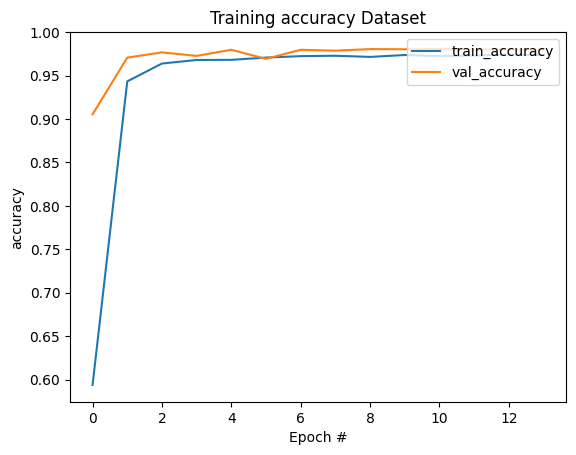

In [37]:
plot_history(history_best_perf_model_aug_rgt_fit)

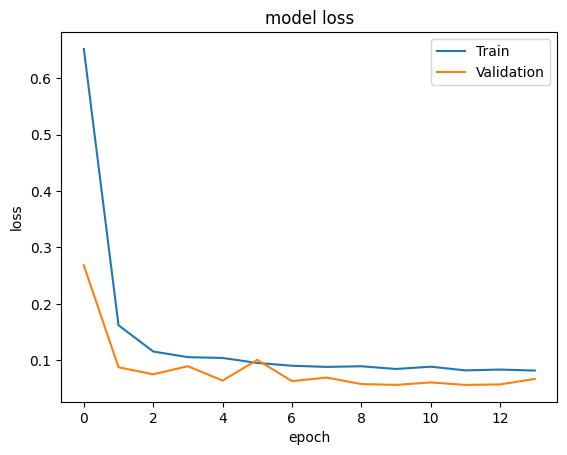

In [38]:
plot_loss(history_best_perf_model_aug_rgt_fit)

### **Training model with augmented data + original data**

In [39]:
# combining augmented images array and original RGB images to simulate a larger training dataset
norm_aug_and_train_images = np.concatenate((aug_rgb_images, norm_train_images))
norm_aug_and_train_encoded_label = np.concatenate((aug_data_encoded_label, train_labels_encoded))

In [48]:
# using model_1 architecture still to compare the results of models trained on different data sets
history_best_perf_model_aug_plus_train_rgb_fit = best_perf_model.fit(norm_aug_and_train_images, norm_aug_and_train_encoded_label, batch_size = 32, callbacks = callbacks, validation_split = 0.2, epochs = 20, verbose = 1)

Epoch 1/20
1248/1248 [==============================] - 12s 9ms/step - loss: 0.0634 - accuracy: 0.9782 - val_loss: 0.0733 - val_accuracy: 0.9769
Epoch 2/20
1248/1248 [==============================] - 11s 9ms/step - loss: 0.0638 - accuracy: 0.9782 - val_loss: 0.0517 - val_accuracy: 0.9861
Epoch 3/20
1248/1248 [==============================] - 11s 9ms/step - loss: 0.0610 - accuracy: 0.9784 - val_loss: 0.0591 - val_accuracy: 0.9803
Epoch 4/20
1248/1248 [==============================] - 11s 9ms/step - loss: 0.0589 - accuracy: 0.9792 - val_loss: 0.0473 - val_accuracy: 0.9857
Epoch 5/20
1248/1248 [==============================] - 11s 9ms/step - loss: 0.0610 - accuracy: 0.9790 - val_loss: 0.0694 - val_accuracy: 0.9821
Epoch 6/20
1248/1248 [==============================] - 11s 9ms/step - loss: 0.0594 - accuracy: 0.9799 - val_loss: 0.0821 - val_accuracy: 0.9776


In [50]:
accuracy_cnn_best_perf_model_aug_plus_train_rgb = best_perf_model.evaluate(norm_test_images, test_labels_encoded, verbose = 1)
accuracy_cnn_best_perf_model_aug_plus_train_rgb

82/82 [==============================] - 0s 4ms/step - loss: 0.0567 - accuracy: 0.9842


[0.05667749419808388, 0.9842307567596436]

In [51]:
pred_cnn_best_perf_model_aug_plus_train_rgb = best_perf_model.predict(norm_test_images)
pred_cnn_best_perf_model_aug_plus_train_rgb = np.argmax(pred_cnn_best_perf_model_aug_plus_train_rgb, axis = 1) 
y_true_cnn_best_perf_aug_plus_train_rgb = np.argmax(test_labels_encoded, axis = 1)
# Printing the classification report
print(classification_report(y_true_cnn_best_perf_aug_plus_train_rgb, pred_cnn_best_perf_model_aug_plus_train_rgb))

82/82 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1300
           1       0.98      0.99      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



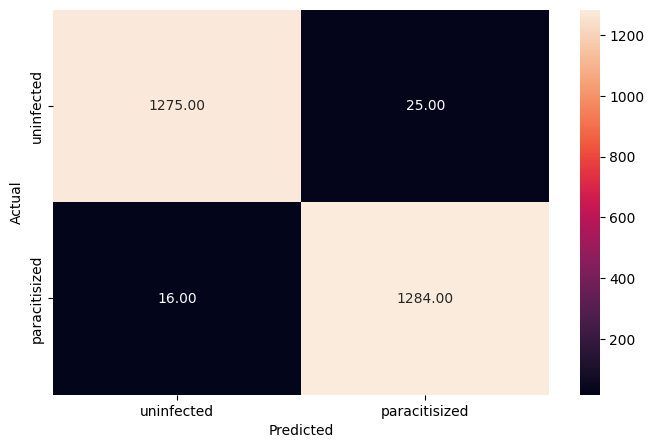

In [52]:
metrics_score(y_true_cnn_best_perf_aug_plus_train_rgb, pred_cnn_best_perf_model_aug_plus_train_rgb)

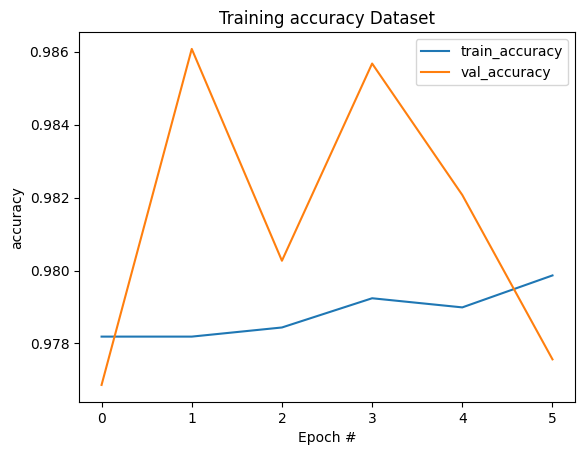

In [53]:
plot_history(history_best_perf_model_aug_plus_train_rgb_fit)

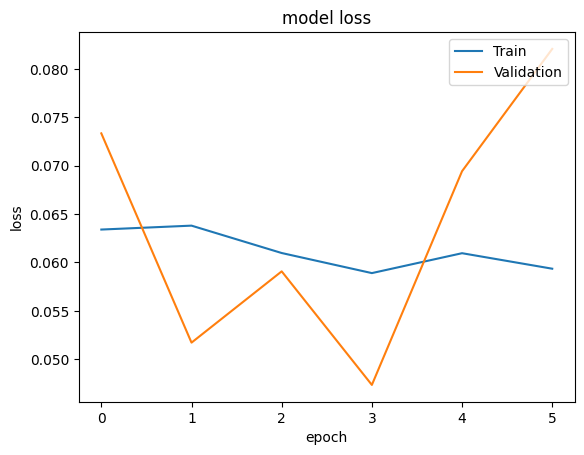

In [54]:
plot_loss(history_best_perf_model_aug_plus_train_rgb_fit)

###**Summary:**
the best performing model (base_model) is selected and trained on only augmented data to determine if the augmented data is representative of the original data, then we combine the augmented data and the original data together to create a dataset that is twice as large as the original dataset and train the model on the combined dataset.

###**Observations and insights:**
*   The performance of model trained on augmented data only shows similar trend as that trained on original data i.e. 98% accuracy and so we conclude that the augmented data is representative of the original data
*   The accuracy of the model trained on augmented + original data shows a slightly improved accuracy (1% higher) which may not be significant - it is worth noting that as the accuracy is already high, we may conclude that the lack of further improvement is due to nearly all patterns from the data has already been learned by the model and the remaining source of error/inconsistancy is difficult to identify, maybe due to the images being of low resolution or other source of uncertainties that require a more sophisticated approach to address

### **Pre-trained model (VGG16)**
- Import VGG16 network upto any layer you choose
- Add Fully Connected Layers on top of it

In [ ]:
from tensorflow.keras import backend
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import Model
import random

In [ ]:
backend.clear_session()
random.seed(42)

In [ ]:
# include_top = False leaves out the top fully-connected layers
vgg_model = VGG16(include_top = False, weights = 'imagenet', input_shape = (64, 64, 3))
transfer_layer = vgg_model.get_layer('block5_pool')
vgg_model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                              

In [ ]:
# freeze all layers of VGG model, making them them non-trainable
for layer in vgg_model.layers:
    layer.trainable = False

In [ ]:
for layer in vgg_model.layers:
    print(layer.name, layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 False
block5_pool False


In [ ]:
model_vgg_transfer = Sequential()

# add convolutional part of VGG16 from above
model_vgg_transfer.add(vgg_model)

# flatten the output as it is from a convolutional layer
model_vgg_transfer.add(Flatten())

# add a dense output layer
model_vgg_transfer.add(Dense(4096, activation='relu'))
model_vgg_transfer.add(Dense(1072, activation='relu'))
model_vgg_transfer.add(Dropout(0.2))
model_vgg_transfer.add(Dense(2, activation='softmax'))

###<b>Compiling the model

In [ ]:
model_vgg_transfer.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_vgg_transfer.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 4096)              8392704   
                                                                 
 dense_1 (Dense)             (None, 1072)              4391984   
                                                                 
 dropout (Dropout)           (None, 1072)              0         
                                                                 
 dense_2 (Dense)             (None, 2)                 2146      
                                                                 
Total params: 27,501,522
Trainable params: 12,786,834
No

<b> using callbacks

In [ ]:
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 2), ModelCheckpoint('.mdl_wts.hdf5', monitor = 'val_loss', save_best_only = True)]

<b>Fit and Train the model

In [ ]:
# train on non augmented data
history_model_vgg_transfer_non_aug = model_vgg_transfer.fit(norm_train_images, train_labels_encoded, batch_size = 32, callbacks = callbacks, validation_split = 0.2, epochs = 20, verbose = 1)

Epoch 1/20
624/624 [==============================] - 15s 24ms/step - loss: 0.1554 - accuracy: 0.9400 - val_loss: 0.0985 - val_accuracy: 0.9722
Epoch 2/20
624/624 [==============================] - 13s 21ms/step - loss: 0.1356 - accuracy: 0.9472 - val_loss: 0.3087 - val_accuracy: 0.8742
Epoch 3/20
624/624 [==============================] - 13s 21ms/step - loss: 0.1268 - accuracy: 0.9509 - val_loss: 0.2055 - val_accuracy: 0.9221


In [ ]:
# train on augmented data
history_model_vgg_transfer_aug_rgb = model_vgg_transfer.fit(train_generator, validation_data = val_generator, batch_size = 32, callbacks = callbacks, epochs = 20, verbose = 1)

Epoch 1/20
312/312 [==============================] - 26s 84ms/step - loss: 0.2512 - accuracy: 0.8986 - val_loss: 0.1659 - val_accuracy: 0.9417
Epoch 2/20
312/312 [==============================] - 25s 80ms/step - loss: 0.2016 - accuracy: 0.9217 - val_loss: 0.1584 - val_accuracy: 0.9377
Epoch 3/20
312/312 [==============================] - 25s 81ms/step - loss: 0.1892 - accuracy: 0.9293 - val_loss: 0.1439 - val_accuracy: 0.9491
Epoch 4/20
312/312 [==============================] - 26s 85ms/step - loss: 0.1924 - accuracy: 0.9239 - val_loss: 0.1671 - val_accuracy: 0.9433
Epoch 5/20
312/312 [==============================] - 25s 79ms/step - loss: 0.1917 - accuracy: 0.9264 - val_loss: 0.1565 - val_accuracy: 0.9425


In [ ]:
# train on augmented data + non augmented data
history_model_vgg_transfer_aug_plus_nonaug_rgb = model_vgg_transfer.fit(norm_aug_and_train_images, norm_aug_and_train_encoded_label, batch_size = 32, callbacks = callbacks, validation_split = 0.2, epochs = 20, verbose = 1)

Epoch 1/20
1248/1248 [==============================] - 27s 22ms/step - loss: 0.1330 - accuracy: 0.9482 - val_loss: 0.1398 - val_accuracy: 0.9681
Epoch 2/20
1248/1248 [==============================] - 26s 21ms/step - loss: 0.1289 - accuracy: 0.9506 - val_loss: 0.3819 - val_accuracy: 0.8603
Epoch 3/20
1248/1248 [==============================] - 27s 21ms/step - loss: 0.1247 - accuracy: 0.9518 - val_loss: 0.0969 - val_accuracy: 0.9782
Epoch 4/20
1248/1248 [==============================] - 26s 21ms/step - loss: 0.1193 - accuracy: 0.9542 - val_loss: 0.3147 - val_accuracy: 0.8967
Epoch 5/20
1248/1248 [==============================] - 26s 21ms/step - loss: 0.1136 - accuracy: 0.9575 - val_loss: 0.1667 - val_accuracy: 0.9542


###<b> Evaluating the model

<b>Plot the train and validation accuracy

In [ ]:
# non augmented data
accuracy_model_vgg_transfer = model_vgg_transfer.evaluate(norm_test_images, test_labels_encoded, verbose = 1)
accuracy_model_vgg_transfer

82/82 [==============================] - 1s 16ms/step - loss: 0.1858 - accuracy: 0.9238


[0.18575702607631683, 0.9238461256027222]

In [ ]:
# augmented data
accuracy_model_vgg_transfer_aug_rgb = model_vgg_transfer.evaluate(norm_test_images, test_labels_encoded, verbose = 1)
accuracy_model_vgg_transfer_aug_rgb

82/82 [==============================] - 2s 19ms/step - loss: 0.2139 - accuracy: 0.9127


[0.2139255404472351, 0.9126923084259033]

In [ ]:
# augmented data + non augmented data
accuracy_model_vgg_transfer_aug_plus_nonaug_rgb = model_vgg_transfer.evaluate(norm_test_images, test_labels_encoded, verbose = 1)
accuracy_model_vgg_transfer_aug_plus_nonaug_rgb

82/82 [==============================] - 1s 16ms/step - loss: 0.1594 - accuracy: 0.9442


[0.1593557596206665, 0.9442307949066162]

<b>Plotting the classification report and confusion matrix

In [ ]:
# non augmented data
pred_model_vgg_transfer = model_vgg_transfer.predict(norm_test_images)
pred_model_vgg_transfer = np.argmax(pred_model_vgg_transfer, axis = 1) 
y_true_model_vgg_transfer = np.argmax(test_labels_encoded, axis = 1)
# Printing the classification report
print(classification_report(y_true_model_vgg_transfer, pred_model_vgg_transfer))

82/82 [==============================] - 1s 14ms/step
              precision    recall  f1-score   support

           0       0.97      0.87      0.92      1300
           1       0.88      0.98      0.93      1300

    accuracy                           0.92      2600
   macro avg       0.93      0.92      0.92      2600
weighted avg       0.93      0.92      0.92      2600



In [ ]:
# augmented data
pred_model_vgg_transfer_aug_rgb = model_vgg_transfer.predict(norm_test_images)
pred_model_vgg_transfer_aug_rgb = np.argmax(pred_model_vgg_transfer_aug_rgb, axis = 1) 
y_true_model_vgg_transfer_aug_rgb = np.argmax(test_labels_encoded, axis = 1)
# Printing the classification report
print(classification_report(y_true_model_vgg_transfer_aug_rgb, pred_model_vgg_transfer_aug_rgb))

82/82 [==============================] - 1s 15ms/step
              precision    recall  f1-score   support

           0       0.98      0.85      0.91      1300
           1       0.86      0.98      0.92      1300

    accuracy                           0.91      2600
   macro avg       0.92      0.91      0.91      2600
weighted avg       0.92      0.91      0.91      2600



In [ ]:
# augmented data + non augmented data
pred_model_vgg_transfer_aug_plus_nonaug_rgb = model_vgg_transfer.predict(norm_test_images)
pred_model_vgg_transfer_aug_plus_nonaug_rgb = np.argmax(pred_model_vgg_transfer_aug_plus_nonaug_rgb, axis = 1) 
y_true_model_vgg_transfer_aug_plus_nonaug_rgb = np.argmax(test_labels_encoded, axis = 1)
# Printing the classification report
print(classification_report(y_true_model_vgg_transfer_aug_plus_nonaug_rgb, pred_model_vgg_transfer_aug_plus_nonaug_rgb))

82/82 [==============================] - 1s 14ms/step
              precision    recall  f1-score   support

           0       0.97      0.92      0.94      1300
           1       0.92      0.97      0.95      1300

    accuracy                           0.94      2600
   macro avg       0.95      0.94      0.94      2600
weighted avg       0.95      0.94      0.94      2600



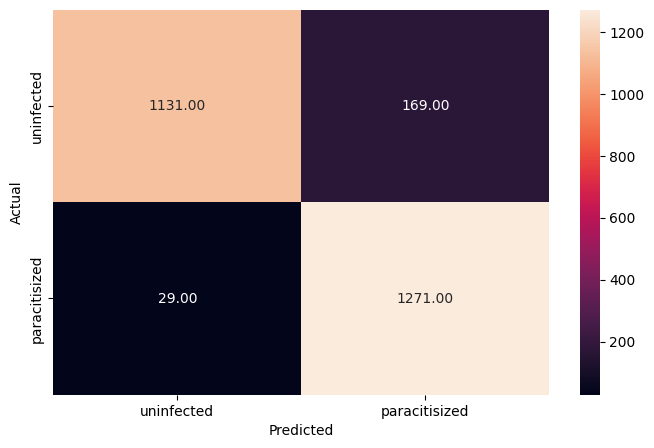

In [ ]:
# non augmented data
metrics_score(y_true_model_vgg_transfer, pred_model_vgg_transfer)

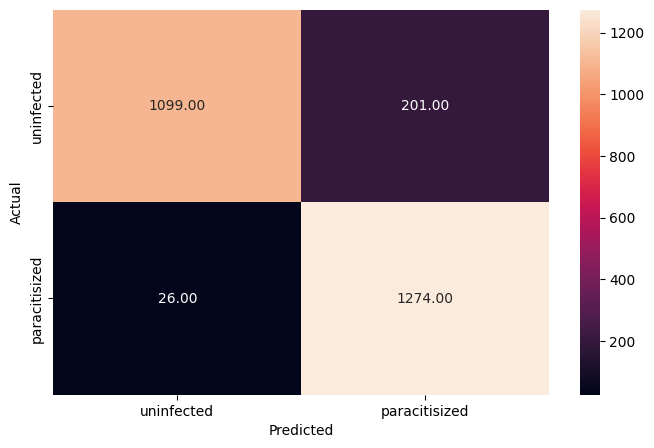

In [ ]:
# augmented data
metrics_score(y_true_model_vgg_transfer_aug_rgb, pred_model_vgg_transfer_aug_rgb)

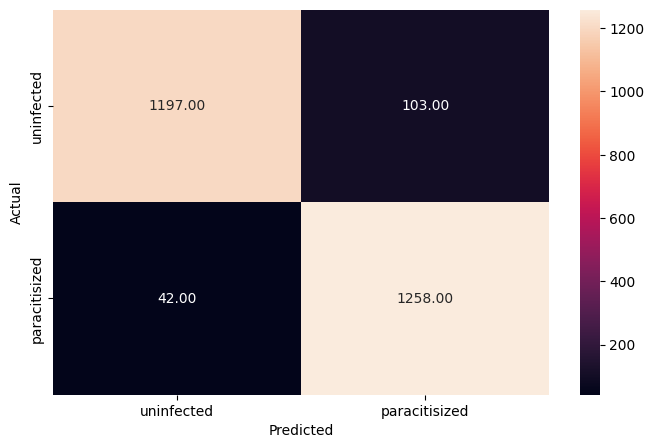

In [ ]:
# augmented data + non augmented data
metrics_score(y_true_model_vgg_transfer_aug_plus_nonaug_rgb, pred_model_vgg_transfer_aug_plus_nonaug_rgb)

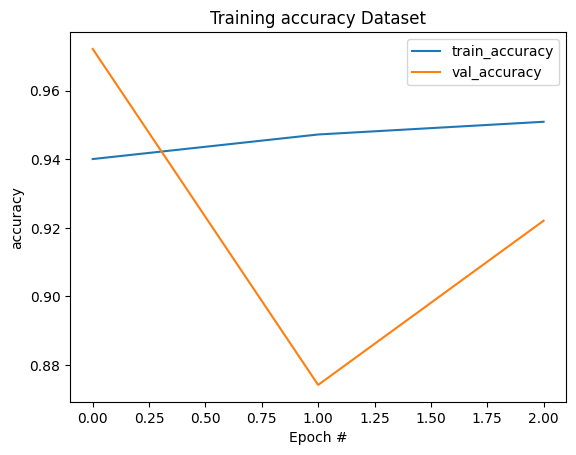

In [ ]:
# non augmented data
plot_history(history_model_vgg_transfer_non_aug)

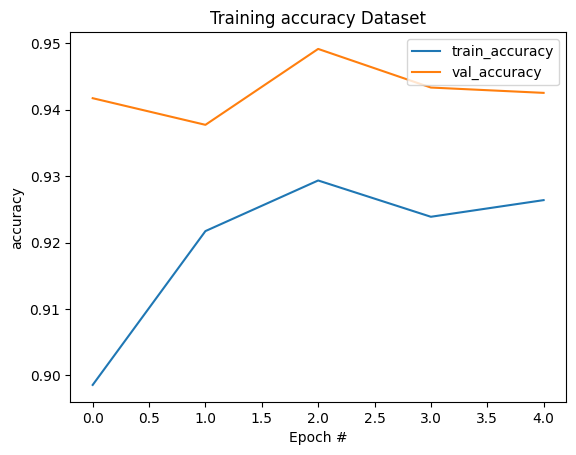

In [ ]:
# augmented data
plot_history(history_model_vgg_transfer_aug_rgb)

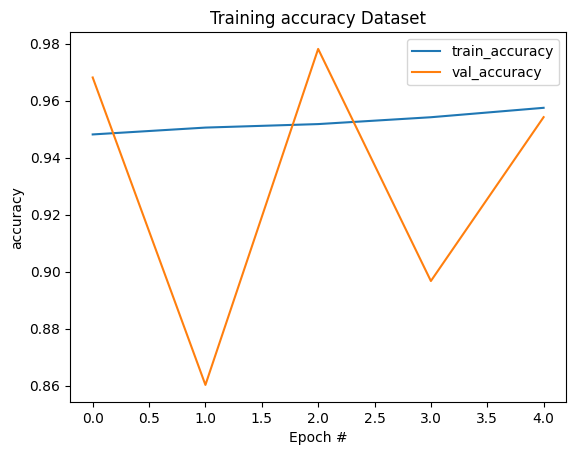

In [ ]:
# augmented data + non augmented data
plot_history(history_model_vgg_transfer_aug_plus_nonaug_rgb)

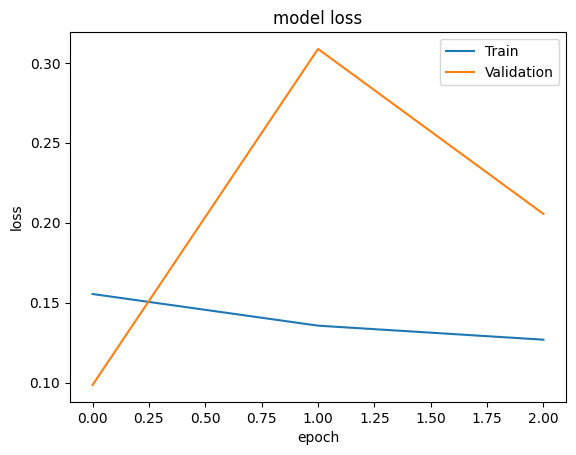

In [ ]:
# non augmented data
plot_loss(history_model_vgg_transfer_non_aug)

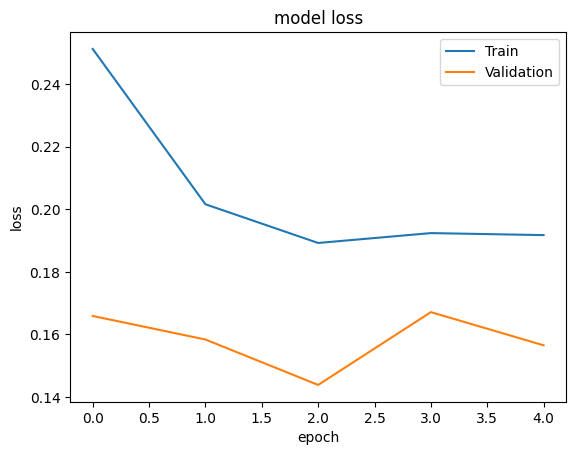

In [ ]:
# augmented data
plot_loss(history_model_vgg_transfer_aug_rgb)

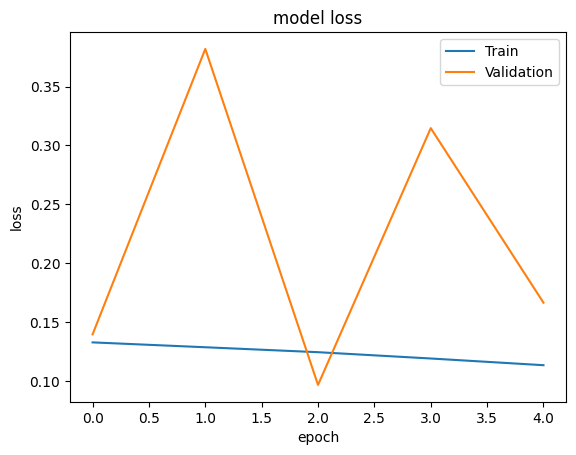

In [ ]:
# augmented data + non augmented data
plot_loss(history_model_vgg_transfer_aug_plus_nonaug_rgb)

###**Observations and insights:**
*   The model performed similarly well when trained on original images and on augmented images, both have the same number of images
*   The model performed best when trained on original + augmented images, this may be due the training being done of twice as many images, allowing the accuracy to increase to 94%, recall to 92% and precision at 97%
*   In all three fits, train accuracies are more stable across the epochs while validation accuracies tend to fluctuate across the epochs
*   accuracy vs epoch plots for the model do not show signs of overfitting when trained on original images, augmented images or on the combination of the two

---

####**Executive Summary (key findings)**:

**Comparison of performance based on the difference in model architectures:**

*   The simple_model has no regularization (e.g. dropout layers) and shows signs of overfitting
*   Out of all custom models, base_model performs the best on test dataset overall, although model_1 and model_2 performed similarly well
    *   all 3 models have accuracies of 98%
    *   base_model has the highest recall rate at 99% followed by model_1 at 97% and model_2 at 96%
    *   model_1 and model_2 both have the precision of 99% while base_model have the precision of 98% on test dataset
*   Pre-trained model (VGG16) shows the lowest overall performance with accuracy at 92%, recall at 86% and precision at 88%

It is possible that VGG16 model does less well than custom models due to:
*   Custom CNN model being trained only on relevant data whereas VGG16 model is more general-purpose and was trained on a large and diverse dataset, making custom model more effective at recognizing relevant features than VGG16 models
*   VGG16 model was trained on large datasets and may overfit on smaller, more specialized datasets, especially as VGG16 has a much more complex architecture with a much higher number of trainable parameters and need a much larger dataset to train on than the custom models 

**Comparison of performance based on preprocessing techniques:**

*   The performance of custom models do not change significantly (only 1-2% difference) with the use of different preprocessing technique, although it is possible that this is because the performance of the model is already very high, denoting that **the model may have already learned to capture most of the relevant patterns in the training data** - although it is worth noting that performing Gaussian blurring on the train dataset followed by HSV image gives the best overall performance with accuracy, recall and precision at 99%
*   Pre-trained VGG16 model fitted on original + augmented images performed slightly better than that trained on only original images or only augmented images, this may be because the model has large number of trainable parameters (12,786,834 params compared to custom models with the largest trainable params, base_model, 4,289,090 params) which require more data to train


####**Final solution design**:
*   Overall, the best performing combination of image processing and model architecture is **base_model architecture trained on Gaussian blurred HSV images** which gives the best performance at 99% for accuracy, recall, precision and f1-score on test dataset


####**Further Improvement:**<br>
*  Further train for variability of parasite appearances as their appearance varies across different stages of development and can also vary due to the varying quality of smear preparation, staining and imaging process
*  From real-world use perspective, further more detailed classification can be made to distinguish different malaria species to better treat patients and give more specilized care as some species of malaria is more virulent than others - this will require further labeling and larger datasets
*  The use of higher resolution train and test datasets to remove any uncertainty and error which may be caused from the use of low resolution images
*  Development of more sophisticated data pre-processing techniques to increase available data for the model to train on and also to remove any noise which may cause error in the classification process

####**Next steps:**<br>
*   Construct program front-end to allow non-technical users to easily interact and use the model to detect malaria parasites in blood cells
*   Evaluate technical infrastructure of possible establishments to deploy the product to and adjust the method of deployment to suit the situation e.g. many areas with high rates of malaria infections in developing countries, there may be regular electricity outages and lack of technical infrastructure such as high-performance computers and data storage